# Sciplex Dose

In [1]:
ood_seed = 11

In [2]:
num_ood = 1

In [3]:
obs_key = "dose_training"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('SAHA', '10.0'), 426)

Removed datapoint: 426


In [11]:
adata

AnnData object with n_obs × n_vars = 14385 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: ne59xc12
Name: carbonite-fighter-452
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/ne59xc12
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_113136-ne59xc12/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1740,1596,1435,1725,1414,1201,1406,991
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 415,365,357,446,376,313,361,244
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:09<1:32:43,  9.29s/it]

Epoch 1/600:   0%|          | 1/600 [00:09<1:32:43,  9.29s/it, v_num=12_1, total_loss_train=2.62e+3, kl_local_train=30.7]

Epoch 2/600:   0%|          | 1/600 [00:09<1:32:43,  9.29s/it, v_num=12_1, total_loss_train=2.62e+3, kl_local_train=30.7]

Epoch 2/600:   0%|          | 2/600 [00:18<1:29:51,  9.02s/it, v_num=12_1, total_loss_train=2.62e+3, kl_local_train=30.7]

Epoch 2/600:   0%|          | 2/600 [00:18<1:29:51,  9.02s/it, v_num=12_1, total_loss_train=2.21e+3, kl_local_train=55.8]

Epoch 3/600:   0%|          | 2/600 [00:18<1:29:51,  9.02s/it, v_num=12_1, total_loss_train=2.21e+3, kl_local_train=55.8]

Epoch 3/600:   0%|          | 3/600 [00:26<1:28:53,  8.93s/it, v_num=12_1, total_loss_train=2.21e+3, kl_local_train=55.8]

Epoch 3/600:   0%|          | 3/600 [00:26<1:28:53,  8.93s/it, v_num=12_1, total_loss_train=2.18e+3, kl_local_train=61.3]

Epoch 4/600:   0%|          | 3/600 [00:26<1:28:53,  8.93s/it, v_num=12_1, total_loss_train=2.18e+3, kl_local_train=61.3]

Epoch 4/600:   1%|          | 4/600 [00:35<1:28:25,  8.90s/it, v_num=12_1, total_loss_train=2.18e+3, kl_local_train=61.3]

Epoch 4/600:   1%|          | 4/600 [00:35<1:28:25,  8.90s/it, v_num=12_1, total_loss_train=2.18e+3, kl_local_train=62.4]

Epoch 5/600:   1%|          | 4/600 [00:35<1:28:25,  8.90s/it, v_num=12_1, total_loss_train=2.18e+3, kl_local_train=62.4]

Epoch 5/600:   1%|          | 5/600 [00:45<1:29:48,  9.06s/it, v_num=12_1, total_loss_train=2.18e+3, kl_local_train=62.4]

Epoch 5/600:   1%|          | 5/600 [00:45<1:29:48,  9.06s/it, v_num=12_1, total_loss_train=2.18e+3, kl_local_train=61.9]

Epoch 6/600:   1%|          | 5/600 [00:45<1:29:48,  9.06s/it, v_num=12_1, total_loss_train=2.18e+3, kl_local_train=61.9]

Epoch 6/600:   1%|          | 6/600 [00:53<1:27:52,  8.88s/it, v_num=12_1, total_loss_train=2.18e+3, kl_local_train=61.9]

Epoch 6/600:   1%|          | 6/600 [00:53<1:27:52,  8.88s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 7/600:   1%|          | 6/600 [00:53<1:27:52,  8.88s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 7/600:   1%|          | 7/600 [01:01<1:25:00,  8.60s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 7/600:   1%|          | 7/600 [01:01<1:25:00,  8.60s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 8/600:   1%|          | 7/600 [01:01<1:25:00,  8.60s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 8/600:   1%|▏         | 8/600 [01:09<1:23:01,  8.41s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 8/600:   1%|▏         | 8/600 [01:09<1:23:01,  8.41s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 9/600:   1%|▏         | 8/600 [01:09<1:23:01,  8.41s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 9/600:   2%|▏         | 9/600 [01:17<1:21:37,  8.29s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 9/600:   2%|▏         | 9/600 [01:17<1:21:37,  8.29s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 10/600:   2%|▏         | 9/600 [01:17<1:21:37,  8.29s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 10/600:   2%|▏         | 10/600 [01:26<1:21:52,  8.33s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 10/600:   2%|▏         | 10/600 [01:26<1:21:52,  8.33s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 11/600:   2%|▏         | 10/600 [01:26<1:21:52,  8.33s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 11/600:   2%|▏         | 11/600 [01:35<1:24:41,  8.63s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0391, metric_mi|condition_train=0.0287]

Epoch 11/600:   2%|▏         | 11/600 [01:35<1:24:41,  8.63s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 12/600:   2%|▏         | 11/600 [01:35<1:24:41,  8.63s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 12/600:   2%|▏         | 12/600 [01:44<1:25:13,  8.70s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 12/600:   2%|▏         | 12/600 [01:44<1:25:13,  8.70s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 13/600:   2%|▏         | 12/600 [01:44<1:25:13,  8.70s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 13/600:   2%|▏         | 13/600 [01:52<1:23:04,  8.49s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 13/600:   2%|▏         | 13/600 [01:52<1:23:04,  8.49s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 14/600:   2%|▏         | 13/600 [01:52<1:23:04,  8.49s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 14/600:   2%|▏         | 14/600 [02:00<1:21:33,  8.35s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 14/600:   2%|▏         | 14/600 [02:00<1:21:33,  8.35s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 15/600:   2%|▏         | 14/600 [02:00<1:21:33,  8.35s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 15/600:   2%|▎         | 15/600 [02:09<1:23:08,  8.53s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 15/600:   2%|▎         | 15/600 [02:09<1:23:08,  8.53s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 16/600:   2%|▎         | 15/600 [02:09<1:23:08,  8.53s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 16/600:   3%|▎         | 16/600 [02:17<1:22:47,  8.51s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0517, metric_mi|condition_train=0.0944]

Epoch 16/600:   3%|▎         | 16/600 [02:17<1:22:47,  8.51s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126] 

Epoch 17/600:   3%|▎         | 16/600 [02:17<1:22:47,  8.51s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 17/600:   3%|▎         | 17/600 [02:25<1:21:08,  8.35s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 17/600:   3%|▎         | 17/600 [02:25<1:21:08,  8.35s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 18/600:   3%|▎         | 17/600 [02:25<1:21:08,  8.35s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 18/600:   3%|▎         | 18/600 [02:33<1:19:57,  8.24s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 18/600:   3%|▎         | 18/600 [02:33<1:19:57,  8.24s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 19/600:   3%|▎         | 18/600 [02:33<1:19:57,  8.24s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 19/600:   3%|▎         | 19/600 [02:41<1:19:07,  8.17s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 19/600:   3%|▎         | 19/600 [02:41<1:19:07,  8.17s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 20/600:   3%|▎         | 19/600 [02:41<1:19:07,  8.17s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 20/600:   3%|▎         | 20/600 [02:49<1:19:17,  8.20s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 20/600:   3%|▎         | 20/600 [02:49<1:19:17,  8.20s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 21/600:   3%|▎         | 20/600 [02:50<1:19:17,  8.20s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 21/600:   4%|▎         | 21/600 [02:58<1:19:47,  8.27s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0602, metric_mi|condition_train=0.126]

Epoch 21/600:   4%|▎         | 21/600 [02:58<1:19:47,  8.27s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 22/600:   4%|▎         | 21/600 [02:58<1:19:47,  8.27s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 22/600:   4%|▎         | 22/600 [03:06<1:18:51,  8.19s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 22/600:   4%|▎         | 22/600 [03:06<1:18:51,  8.19s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]  

Epoch 23/600:   4%|▎         | 22/600 [03:06<1:18:51,  8.19s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 23/600:   4%|▍         | 23/600 [03:14<1:18:05,  8.12s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 23/600:   4%|▍         | 23/600 [03:14<1:18:05,  8.12s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 24/600:   4%|▍         | 23/600 [03:14<1:18:05,  8.12s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 24/600:   4%|▍         | 24/600 [03:22<1:17:30,  8.07s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 24/600:   4%|▍         | 24/600 [03:22<1:17:30,  8.07s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 25/600:   4%|▍         | 24/600 [03:22<1:17:30,  8.07s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 25/600:   4%|▍         | 25/600 [03:30<1:18:42,  8.21s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 25/600:   4%|▍         | 25/600 [03:30<1:18:42,  8.21s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 26/600:   4%|▍         | 25/600 [03:31<1:18:42,  8.21s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 26/600:   4%|▍         | 26/600 [03:39<1:19:05,  8.27s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0594, metric_mi|condition_train=0.116]

Epoch 26/600:   4%|▍         | 26/600 [03:39<1:19:05,  8.27s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 27/600:   4%|▍         | 26/600 [03:39<1:19:05,  8.27s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 27/600:   4%|▍         | 27/600 [03:47<1:18:09,  8.18s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 27/600:   4%|▍         | 27/600 [03:47<1:18:09,  8.18s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 28/600:   4%|▍         | 27/600 [03:47<1:18:09,  8.18s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 28/600:   5%|▍         | 28/600 [03:55<1:17:25,  8.12s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 28/600:   5%|▍         | 28/600 [03:55<1:17:25,  8.12s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 29/600:   5%|▍         | 28/600 [03:55<1:17:25,  8.12s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 29/600:   5%|▍         | 29/600 [04:03<1:16:55,  8.08s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 29/600:   5%|▍         | 29/600 [04:03<1:16:55,  8.08s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 30/600:   5%|▍         | 29/600 [04:03<1:16:55,  8.08s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 30/600:   5%|▌         | 30/600 [04:11<1:17:15,  8.13s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 30/600:   5%|▌         | 30/600 [04:11<1:17:15,  8.13s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 31/600:   5%|▌         | 30/600 [04:11<1:17:15,  8.13s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 31/600:   5%|▌         | 31/600 [04:19<1:17:56,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0593, metric_mi|condition_train=0.112]

Epoch 31/600:   5%|▌         | 31/600 [04:19<1:17:56,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 32/600:   5%|▌         | 31/600 [04:19<1:17:56,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 32/600:   5%|▌         | 32/600 [04:27<1:17:10,  8.15s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 32/600:   5%|▌         | 32/600 [04:27<1:17:10,  8.15s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 33/600:   5%|▌         | 32/600 [04:27<1:17:10,  8.15s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 33/600:   6%|▌         | 33/600 [04:35<1:16:30,  8.10s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 33/600:   6%|▌         | 33/600 [04:35<1:16:30,  8.10s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 34/600:   6%|▌         | 33/600 [04:35<1:16:30,  8.10s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 34/600:   6%|▌         | 34/600 [04:43<1:16:06,  8.07s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 34/600:   6%|▌         | 34/600 [04:43<1:16:06,  8.07s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 35/600:   6%|▌         | 34/600 [04:43<1:16:06,  8.07s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 35/600:   6%|▌         | 35/600 [04:52<1:16:28,  8.12s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 35/600:   6%|▌         | 35/600 [04:52<1:16:28,  8.12s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 36/600:   6%|▌         | 35/600 [04:52<1:16:28,  8.12s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 36/600:   6%|▌         | 36/600 [05:00<1:17:13,  8.22s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0589, metric_mi|condition_train=0.104]

Epoch 36/600:   6%|▌         | 36/600 [05:00<1:17:13,  8.22s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=51, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959] 

Epoch 37/600:   6%|▌         | 36/600 [05:00<1:17:13,  8.22s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=51, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 37/600:   6%|▌         | 37/600 [05:08<1:16:24,  8.14s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=51, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 37/600:   6%|▌         | 37/600 [05:08<1:16:24,  8.14s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 38/600:   6%|▌         | 37/600 [05:08<1:16:24,  8.14s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 38/600:   6%|▋         | 38/600 [05:16<1:15:47,  8.09s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 38/600:   6%|▋         | 38/600 [05:16<1:15:47,  8.09s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 39/600:   6%|▋         | 38/600 [05:16<1:15:47,  8.09s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 39/600:   6%|▋         | 39/600 [05:24<1:15:16,  8.05s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 39/600:   6%|▋         | 39/600 [05:24<1:15:16,  8.05s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 40/600:   6%|▋         | 39/600 [05:24<1:15:16,  8.05s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 40/600:   7%|▋         | 40/600 [05:33<1:16:35,  8.21s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 40/600:   7%|▋         | 40/600 [05:33<1:16:35,  8.21s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 41/600:   7%|▋         | 40/600 [05:33<1:16:35,  8.21s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 41/600:   7%|▋         | 41/600 [05:41<1:17:02,  8.27s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0597, metric_mi|condition_train=0.0959]

Epoch 41/600:   7%|▋         | 41/600 [05:41<1:17:02,  8.27s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 42/600:   7%|▋         | 41/600 [05:41<1:17:02,  8.27s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 42/600:   7%|▋         | 42/600 [05:49<1:16:06,  8.18s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 42/600:   7%|▋         | 42/600 [05:49<1:16:06,  8.18s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 43/600:   7%|▋         | 42/600 [05:49<1:16:06,  8.18s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 43/600:   7%|▋         | 43/600 [05:57<1:15:22,  8.12s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 43/600:   7%|▋         | 43/600 [05:57<1:15:22,  8.12s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=53, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]  

Epoch 44/600:   7%|▋         | 43/600 [05:57<1:15:22,  8.12s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=53, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 44/600:   7%|▋         | 44/600 [06:05<1:14:49,  8.07s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=53, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 44/600:   7%|▋         | 44/600 [06:05<1:14:49,  8.07s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 45/600:   7%|▋         | 44/600 [06:05<1:14:49,  8.07s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 45/600:   8%|▊         | 45/600 [06:13<1:16:00,  8.22s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 45/600:   8%|▊         | 45/600 [06:13<1:16:00,  8.22s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 46/600:   8%|▊         | 45/600 [06:14<1:16:00,  8.22s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 46/600:   8%|▊         | 46/600 [06:22<1:16:25,  8.28s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0905]

Epoch 46/600:   8%|▊         | 46/600 [06:22<1:16:25,  8.28s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 47/600:   8%|▊         | 46/600 [06:22<1:16:25,  8.28s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 47/600:   8%|▊         | 47/600 [06:30<1:15:22,  8.18s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 47/600:   8%|▊         | 47/600 [06:30<1:15:22,  8.18s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=57, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]  

Epoch 48/600:   8%|▊         | 47/600 [06:30<1:15:22,  8.18s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=57, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 48/600:   8%|▊         | 48/600 [06:38<1:14:35,  8.11s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=57, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 48/600:   8%|▊         | 48/600 [06:38<1:14:35,  8.11s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 49/600:   8%|▊         | 48/600 [06:38<1:14:35,  8.11s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 49/600:   8%|▊         | 49/600 [06:46<1:14:02,  8.06s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 49/600:   8%|▊         | 49/600 [06:46<1:14:02,  8.06s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 50/600:   8%|▊         | 49/600 [06:46<1:14:02,  8.06s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 50/600:   8%|▊         | 50/600 [06:54<1:14:53,  8.17s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 50/600:   8%|▊         | 50/600 [06:54<1:14:53,  8.17s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 51/600:   8%|▊         | 50/600 [06:55<1:14:53,  8.17s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 51/600:   8%|▊         | 51/600 [07:02<1:15:21,  8.24s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0899]

Epoch 51/600:   8%|▊         | 51/600 [07:02<1:15:21,  8.24s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]  

Epoch 52/600:   8%|▊         | 51/600 [07:02<1:15:21,  8.24s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 52/600:   9%|▊         | 52/600 [07:10<1:14:25,  8.15s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 52/600:   9%|▊         | 52/600 [07:10<1:14:25,  8.15s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 53/600:   9%|▊         | 52/600 [07:10<1:14:25,  8.15s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 53/600:   9%|▉         | 53/600 [07:18<1:13:45,  8.09s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 53/600:   9%|▉         | 53/600 [07:18<1:13:45,  8.09s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 54/600:   9%|▉         | 53/600 [07:18<1:13:45,  8.09s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 54/600:   9%|▉         | 54/600 [07:26<1:13:13,  8.05s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=58.5, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 54/600:   9%|▉         | 54/600 [07:26<1:13:13,  8.05s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 55/600:   9%|▉         | 54/600 [07:26<1:13:13,  8.05s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 55/600:   9%|▉         | 55/600 [07:35<1:13:54,  8.14s/it, v_num=12_1, total_loss_train=2.17e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 55/600:   9%|▉         | 55/600 [07:35<1:13:54,  8.14s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 56/600:   9%|▉         | 55/600 [07:35<1:13:54,  8.14s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 56/600:   9%|▉         | 56/600 [07:43<1:14:35,  8.23s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.065, metric_mi|condition_train=0.087]

Epoch 56/600:   9%|▉         | 56/600 [07:43<1:14:35,  8.23s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 57/600:   9%|▉         | 56/600 [07:43<1:14:35,  8.23s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 57/600:  10%|▉         | 57/600 [07:51<1:13:49,  8.16s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 57/600:  10%|▉         | 57/600 [07:51<1:13:49,  8.16s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 58/600:  10%|▉         | 57/600 [07:51<1:13:49,  8.16s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 58/600:  10%|▉         | 58/600 [07:59<1:13:16,  8.11s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 58/600:  10%|▉         | 58/600 [07:59<1:13:16,  8.11s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 59/600:  10%|▉         | 58/600 [07:59<1:13:16,  8.11s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 59/600:  10%|▉         | 59/600 [08:07<1:12:49,  8.08s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 59/600:  10%|▉         | 59/600 [08:07<1:12:49,  8.08s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 60/600:  10%|▉         | 59/600 [08:07<1:12:49,  8.08s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 60/600:  10%|█         | 60/600 [08:16<1:13:53,  8.21s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 60/600:  10%|█         | 60/600 [08:16<1:13:53,  8.21s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 61/600:  10%|█         | 60/600 [08:16<1:13:53,  8.21s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 61/600:  10%|█         | 61/600 [08:24<1:14:36,  8.31s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0854]

Epoch 61/600:  10%|█         | 61/600 [08:24<1:14:36,  8.31s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 62/600:  10%|█         | 61/600 [08:24<1:14:36,  8.31s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 62/600:  10%|█         | 62/600 [08:32<1:13:52,  8.24s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 62/600:  10%|█         | 62/600 [08:32<1:13:52,  8.24s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 63/600:  10%|█         | 62/600 [08:32<1:13:52,  8.24s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 63/600:  10%|█         | 63/600 [08:40<1:13:16,  8.19s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=63.8, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 63/600:  10%|█         | 63/600 [08:40<1:13:16,  8.19s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 64/600:  10%|█         | 63/600 [08:40<1:13:16,  8.19s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 64/600:  11%|█         | 64/600 [08:48<1:12:51,  8.16s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 64/600:  11%|█         | 64/600 [08:48<1:12:51,  8.16s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 65/600:  11%|█         | 64/600 [08:48<1:12:51,  8.16s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 65/600:  11%|█         | 65/600 [08:57<1:13:06,  8.20s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 65/600:  11%|█         | 65/600 [08:57<1:13:06,  8.20s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 66/600:  11%|█         | 65/600 [08:57<1:13:06,  8.20s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 66/600:  11%|█         | 66/600 [09:05<1:13:50,  8.30s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0836]

Epoch 66/600:  11%|█         | 66/600 [09:05<1:13:50,  8.30s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 67/600:  11%|█         | 66/600 [09:05<1:13:50,  8.30s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 67/600:  11%|█         | 67/600 [09:13<1:13:16,  8.25s/it, v_num=12_1, total_loss_train=2.16e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 67/600:  11%|█         | 67/600 [09:13<1:13:16,  8.25s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 68/600:  11%|█         | 67/600 [09:13<1:13:16,  8.25s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 68/600:  11%|█▏        | 68/600 [09:21<1:12:45,  8.21s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 68/600:  11%|█▏        | 68/600 [09:21<1:12:45,  8.21s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 69/600:  11%|█▏        | 68/600 [09:21<1:12:45,  8.21s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 69/600:  12%|█▏        | 69/600 [09:30<1:12:28,  8.19s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 69/600:  12%|█▏        | 69/600 [09:30<1:12:28,  8.19s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 70/600:  12%|█▏        | 69/600 [09:30<1:12:28,  8.19s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 70/600:  12%|█▏        | 70/600 [09:38<1:13:38,  8.34s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=65.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 70/600:  12%|█▏        | 70/600 [09:38<1:13:38,  8.34s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=64.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 71/600:  12%|█▏        | 70/600 [09:39<1:13:38,  8.34s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=64.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 71/600:  12%|█▏        | 71/600 [09:47<1:14:10,  8.41s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=64.7, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0839]

Epoch 71/600:  12%|█▏        | 71/600 [09:47<1:14:10,  8.41s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 72/600:  12%|█▏        | 71/600 [09:47<1:14:10,  8.41s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 72/600:  12%|█▏        | 72/600 [09:55<1:13:16,  8.33s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 72/600:  12%|█▏        | 72/600 [09:55<1:13:16,  8.33s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 73/600:  12%|█▏        | 72/600 [09:55<1:13:16,  8.33s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 73/600:  12%|█▏        | 73/600 [10:03<1:12:34,  8.26s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 73/600:  12%|█▏        | 73/600 [10:03<1:12:34,  8.26s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 74/600:  12%|█▏        | 73/600 [10:03<1:12:34,  8.26s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 74/600:  12%|█▏        | 74/600 [10:11<1:12:04,  8.22s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 74/600:  12%|█▏        | 74/600 [10:11<1:12:04,  8.22s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 75/600:  12%|█▏        | 74/600 [10:11<1:12:04,  8.22s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 75/600:  12%|█▎        | 75/600 [10:20<1:12:16,  8.26s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 75/600:  12%|█▎        | 75/600 [10:20<1:12:16,  8.26s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 76/600:  12%|█▎        | 75/600 [10:20<1:12:16,  8.26s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 76/600:  13%|█▎        | 76/600 [10:28<1:12:40,  8.32s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=66.4, metric_mi|dose_training_train=0.0744, metric_mi|condition_train=0.0825]

Epoch 76/600:  13%|█▎        | 76/600 [10:28<1:12:40,  8.32s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 77/600:  13%|█▎        | 76/600 [10:28<1:12:40,  8.32s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 77/600:  13%|█▎        | 77/600 [10:36<1:11:43,  8.23s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 77/600:  13%|█▎        | 77/600 [10:36<1:11:43,  8.23s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 78/600:  13%|█▎        | 77/600 [10:36<1:11:43,  8.23s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 78/600:  13%|█▎        | 78/600 [10:44<1:11:04,  8.17s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 78/600:  13%|█▎        | 78/600 [10:44<1:11:04,  8.17s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 79/600:  13%|█▎        | 78/600 [10:44<1:11:04,  8.17s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 79/600:  13%|█▎        | 79/600 [10:52<1:10:39,  8.14s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=62.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 79/600:  13%|█▎        | 79/600 [10:52<1:10:39,  8.14s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 80/600:  13%|█▎        | 79/600 [10:52<1:10:39,  8.14s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 80/600:  13%|█▎        | 80/600 [11:00<1:10:55,  8.18s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 80/600:  13%|█▎        | 80/600 [11:00<1:10:55,  8.18s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 81/600:  13%|█▎        | 80/600 [11:01<1:10:55,  8.18s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 81/600:  14%|█▎        | 81/600 [11:09<1:11:32,  8.27s/it, v_num=12_1, total_loss_train=2.15e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.0816]

Epoch 81/600:  14%|█▎        | 81/600 [11:09<1:11:32,  8.27s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 82/600:  14%|█▎        | 81/600 [11:09<1:11:32,  8.27s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 82/600:  14%|█▎        | 82/600 [11:17<1:10:46,  8.20s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 82/600:  14%|█▎        | 82/600 [11:17<1:10:46,  8.20s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]  

Epoch 83/600:  14%|█▎        | 82/600 [11:17<1:10:46,  8.20s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 83/600:  14%|█▍        | 83/600 [11:25<1:10:11,  8.15s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=60, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 83/600:  14%|█▍        | 83/600 [11:25<1:10:11,  8.15s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 84/600:  14%|█▍        | 83/600 [11:25<1:10:11,  8.15s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 84/600:  14%|█▍        | 84/600 [11:33<1:09:46,  8.11s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 84/600:  14%|█▍        | 84/600 [11:33<1:09:46,  8.11s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 85/600:  14%|█▍        | 84/600 [11:33<1:09:46,  8.11s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 85/600:  14%|█▍        | 85/600 [11:41<1:10:34,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 85/600:  14%|█▍        | 85/600 [11:41<1:10:34,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 86/600:  14%|█▍        | 85/600 [11:42<1:10:34,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 86/600:  14%|█▍        | 86/600 [11:50<1:11:05,  8.30s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.0798]

Epoch 86/600:  14%|█▍        | 86/600 [11:50<1:11:05,  8.30s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 87/600:  14%|█▍        | 86/600 [11:50<1:11:05,  8.30s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 87/600:  14%|█▍        | 87/600 [11:58<1:10:16,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 87/600:  14%|█▍        | 87/600 [11:58<1:10:16,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 88/600:  14%|█▍        | 87/600 [11:58<1:10:16,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 88/600:  15%|█▍        | 88/600 [12:06<1:09:40,  8.17s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 88/600:  15%|█▍        | 88/600 [12:06<1:09:40,  8.17s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 89/600:  15%|█▍        | 88/600 [12:06<1:09:40,  8.17s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 89/600:  15%|█▍        | 89/600 [12:14<1:09:11,  8.12s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 89/600:  15%|█▍        | 89/600 [12:14<1:09:11,  8.12s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]  

Epoch 90/600:  15%|█▍        | 89/600 [12:14<1:09:11,  8.12s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 90/600:  15%|█▌        | 90/600 [12:23<1:09:51,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 90/600:  15%|█▌        | 90/600 [12:23<1:09:51,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 91/600:  15%|█▌        | 90/600 [12:23<1:09:51,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 91/600:  15%|█▌        | 91/600 [12:31<1:10:22,  8.30s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0787]

Epoch 91/600:  15%|█▌        | 91/600 [12:31<1:10:22,  8.30s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766] 

Epoch 92/600:  15%|█▌        | 91/600 [12:31<1:10:22,  8.30s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 92/600:  15%|█▌        | 92/600 [12:39<1:09:35,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 92/600:  15%|█▌        | 92/600 [12:39<1:09:35,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 93/600:  15%|█▌        | 92/600 [12:39<1:09:35,  8.22s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 93/600:  16%|█▌        | 93/600 [12:47<1:09:00,  8.17s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 93/600:  16%|█▌        | 93/600 [12:47<1:09:00,  8.17s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 94/600:  16%|█▌        | 93/600 [12:47<1:09:00,  8.17s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 94/600:  16%|█▌        | 94/600 [12:55<1:08:32,  8.13s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 94/600:  16%|█▌        | 94/600 [12:55<1:08:32,  8.13s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 95/600:  16%|█▌        | 94/600 [12:55<1:08:32,  8.13s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 95/600:  16%|█▌        | 95/600 [13:04<1:09:27,  8.25s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 95/600:  16%|█▌        | 95/600 [13:04<1:09:27,  8.25s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 96/600:  16%|█▌        | 95/600 [13:04<1:09:27,  8.25s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 96/600:  16%|█▌        | 96/600 [13:12<1:09:52,  8.32s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.0766]

Epoch 96/600:  16%|█▌        | 96/600 [13:12<1:09:52,  8.32s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 97/600:  16%|█▌        | 96/600 [13:12<1:09:52,  8.32s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 97/600:  16%|█▌        | 97/600 [13:20<1:09:00,  8.23s/it, v_num=12_1, total_loss_train=2.14e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 97/600:  16%|█▌        | 97/600 [13:20<1:09:00,  8.23s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=57, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]  

Epoch 98/600:  16%|█▌        | 97/600 [13:20<1:09:00,  8.23s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=57, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 98/600:  16%|█▋        | 98/600 [13:28<1:08:19,  8.17s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=57, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 98/600:  16%|█▋        | 98/600 [13:28<1:08:19,  8.17s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 99/600:  16%|█▋        | 98/600 [13:28<1:08:19,  8.17s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 99/600:  16%|█▋        | 99/600 [13:36<1:07:47,  8.12s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 99/600:  16%|█▋        | 99/600 [13:36<1:07:47,  8.12s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]  

Epoch 100/600:  16%|█▋        | 99/600 [13:36<1:07:47,  8.12s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 100/600:  17%|█▋        | 100/600 [13:45<1:08:34,  8.23s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 100/600:  17%|█▋        | 100/600 [13:45<1:08:34,  8.23s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 101/600:  17%|█▋        | 100/600 [13:45<1:08:34,  8.23s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 101/600:  17%|█▋        | 101/600 [13:53<1:09:00,  8.30s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0787, metric_mi|condition_train=0.0761]

Epoch 101/600:  17%|█▋        | 101/600 [13:53<1:09:00,  8.30s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]  

Epoch 102/600:  17%|█▋        | 101/600 [13:53<1:09:00,  8.30s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 102/600:  17%|█▋        | 102/600 [14:01<1:08:10,  8.21s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 102/600:  17%|█▋        | 102/600 [14:01<1:08:10,  8.21s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 103/600:  17%|█▋        | 102/600 [14:01<1:08:10,  8.21s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 103/600:  17%|█▋        | 103/600 [14:09<1:07:30,  8.15s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 103/600:  17%|█▋        | 103/600 [14:09<1:07:30,  8.15s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 104/600:  17%|█▋        | 103/600 [14:09<1:07:30,  8.15s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 104/600:  17%|█▋        | 104/600 [14:17<1:07:04,  8.11s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 104/600:  17%|█▋        | 104/600 [14:17<1:07:04,  8.11s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 105/600:  17%|█▋        | 104/600 [14:17<1:07:04,  8.11s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 105/600:  18%|█▊        | 105/600 [14:26<1:08:09,  8.26s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 105/600:  18%|█▊        | 105/600 [14:26<1:08:09,  8.26s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 106/600:  18%|█▊        | 105/600 [14:26<1:08:09,  8.26s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 106/600:  18%|█▊        | 106/600 [14:34<1:08:30,  8.32s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.08, metric_mi|condition_train=0.0757]

Epoch 106/600:  18%|█▊        | 106/600 [14:34<1:08:30,  8.32s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 107/600:  18%|█▊        | 106/600 [14:34<1:08:30,  8.32s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 107/600:  18%|█▊        | 107/600 [14:42<1:07:38,  8.23s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 107/600:  18%|█▊        | 107/600 [14:42<1:07:38,  8.23s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 108/600:  18%|█▊        | 107/600 [14:42<1:07:38,  8.23s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 108/600:  18%|█▊        | 108/600 [14:50<1:07:06,  8.18s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 108/600:  18%|█▊        | 108/600 [14:50<1:07:06,  8.18s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 109/600:  18%|█▊        | 108/600 [14:50<1:07:06,  8.18s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 109/600:  18%|█▊        | 109/600 [14:58<1:06:40,  8.15s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 109/600:  18%|█▊        | 109/600 [14:58<1:06:40,  8.15s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 110/600:  18%|█▊        | 109/600 [14:58<1:06:40,  8.15s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 110/600:  18%|█▊        | 110/600 [15:07<1:07:31,  8.27s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 110/600:  18%|█▊        | 110/600 [15:07<1:07:31,  8.27s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 111/600:  18%|█▊        | 110/600 [15:07<1:07:31,  8.27s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 111/600:  18%|█▊        | 111/600 [15:16<1:08:06,  8.36s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0802, metric_mi|condition_train=0.0747]

Epoch 111/600:  18%|█▊        | 111/600 [15:16<1:08:06,  8.36s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 112/600:  18%|█▊        | 111/600 [15:16<1:08:06,  8.36s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 112/600:  19%|█▊        | 112/600 [15:23<1:06:59,  8.24s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 112/600:  19%|█▊        | 112/600 [15:23<1:06:59,  8.24s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 113/600:  19%|█▊        | 112/600 [15:23<1:06:59,  8.24s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 113/600:  19%|█▉        | 113/600 [15:31<1:06:09,  8.15s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 113/600:  19%|█▉        | 113/600 [15:31<1:06:09,  8.15s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 114/600:  19%|█▉        | 113/600 [15:31<1:06:09,  8.15s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 114/600:  19%|█▉        | 114/600 [15:39<1:05:29,  8.09s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 114/600:  19%|█▉        | 114/600 [15:39<1:05:29,  8.09s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 115/600:  19%|█▉        | 114/600 [15:39<1:05:29,  8.09s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 115/600:  19%|█▉        | 115/600 [15:48<1:06:16,  8.20s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 115/600:  19%|█▉        | 115/600 [15:48<1:06:16,  8.20s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]  

Epoch 116/600:  19%|█▉        | 115/600 [15:48<1:06:16,  8.20s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 116/600:  19%|█▉        | 116/600 [15:56<1:06:25,  8.24s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0748]

Epoch 116/600:  19%|█▉        | 116/600 [15:56<1:06:25,  8.24s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 117/600:  19%|█▉        | 116/600 [15:56<1:06:25,  8.24s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 117/600:  20%|█▉        | 117/600 [16:04<1:05:30,  8.14s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 117/600:  20%|█▉        | 117/600 [16:04<1:05:30,  8.14s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 118/600:  20%|█▉        | 117/600 [16:04<1:05:30,  8.14s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 118/600:  20%|█▉        | 118/600 [16:12<1:04:48,  8.07s/it, v_num=12_1, total_loss_train=2.13e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 118/600:  20%|█▉        | 118/600 [16:12<1:04:48,  8.07s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 119/600:  20%|█▉        | 118/600 [16:12<1:04:48,  8.07s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 119/600:  20%|█▉        | 119/600 [16:20<1:04:18,  8.02s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=51.8, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 119/600:  20%|█▉        | 119/600 [16:20<1:04:18,  8.02s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 120/600:  20%|█▉        | 119/600 [16:20<1:04:18,  8.02s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 120/600:  20%|██        | 120/600 [16:28<1:04:24,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 120/600:  20%|██        | 120/600 [16:28<1:04:24,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]  

Epoch 121/600:  20%|██        | 120/600 [16:28<1:04:24,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 121/600:  20%|██        | 121/600 [16:36<1:04:58,  8.14s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52, metric_mi|dose_training_train=0.0822, metric_mi|condition_train=0.0733]

Epoch 121/600:  20%|██        | 121/600 [16:36<1:04:58,  8.14s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 122/600:  20%|██        | 121/600 [16:36<1:04:58,  8.14s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 122/600:  20%|██        | 122/600 [16:44<1:04:18,  8.07s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 122/600:  20%|██        | 122/600 [16:44<1:04:18,  8.07s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]  

Epoch 123/600:  20%|██        | 122/600 [16:44<1:04:18,  8.07s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 123/600:  20%|██        | 123/600 [16:52<1:03:45,  8.02s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=52, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 123/600:  20%|██        | 123/600 [16:52<1:03:45,  8.02s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 124/600:  20%|██        | 123/600 [16:52<1:03:45,  8.02s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 124/600:  21%|██        | 124/600 [17:00<1:03:20,  7.98s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 124/600:  21%|██        | 124/600 [17:00<1:03:20,  7.98s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 125/600:  21%|██        | 124/600 [17:00<1:03:20,  7.98s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 125/600:  21%|██        | 125/600 [17:09<1:04:24,  8.14s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 125/600:  21%|██        | 125/600 [17:09<1:04:24,  8.14s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 126/600:  21%|██        | 125/600 [17:09<1:04:24,  8.14s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 126/600:  21%|██        | 126/600 [17:17<1:04:46,  8.20s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0817, metric_mi|condition_train=0.0719]

Epoch 126/600:  21%|██        | 126/600 [17:17<1:04:46,  8.20s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 127/600:  21%|██        | 126/600 [17:17<1:04:46,  8.20s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 127/600:  21%|██        | 127/600 [17:25<1:03:54,  8.11s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 127/600:  21%|██        | 127/600 [17:25<1:03:54,  8.11s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 128/600:  21%|██        | 127/600 [17:25<1:03:54,  8.11s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 128/600:  21%|██▏       | 128/600 [17:33<1:03:16,  8.04s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 128/600:  21%|██▏       | 128/600 [17:33<1:03:16,  8.04s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 129/600:  21%|██▏       | 128/600 [17:33<1:03:16,  8.04s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 129/600:  22%|██▏       | 129/600 [17:41<1:02:47,  8.00s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 129/600:  22%|██▏       | 129/600 [17:41<1:02:47,  8.00s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 130/600:  22%|██▏       | 129/600 [17:41<1:02:47,  8.00s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 130/600:  22%|██▏       | 130/600 [17:49<1:02:56,  8.03s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 130/600:  22%|██▏       | 130/600 [17:49<1:02:56,  8.03s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 131/600:  22%|██▏       | 130/600 [17:49<1:02:56,  8.03s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 131/600:  22%|██▏       | 131/600 [17:57<1:03:28,  8.12s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.8, metric_mi|dose_training_train=0.0815, metric_mi|condition_train=0.0714]

Epoch 131/600:  22%|██▏       | 131/600 [17:57<1:03:28,  8.12s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 132/600:  22%|██▏       | 131/600 [17:57<1:03:28,  8.12s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 132/600:  22%|██▏       | 132/600 [18:05<1:02:48,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 132/600:  22%|██▏       | 132/600 [18:05<1:02:48,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 133/600:  22%|██▏       | 132/600 [18:05<1:02:48,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 133/600:  22%|██▏       | 133/600 [18:13<1:02:17,  8.00s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 133/600:  22%|██▏       | 133/600 [18:13<1:02:17,  8.00s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 134/600:  22%|██▏       | 133/600 [18:13<1:02:17,  8.00s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 134/600:  22%|██▏       | 134/600 [18:21<1:01:55,  7.97s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 134/600:  22%|██▏       | 134/600 [18:21<1:01:55,  7.97s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 135/600:  22%|██▏       | 134/600 [18:21<1:01:55,  7.97s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 135/600:  22%|██▎       | 135/600 [18:29<1:02:23,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 135/600:  22%|██▎       | 135/600 [18:29<1:02:23,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 136/600:  22%|██▎       | 135/600 [18:29<1:02:23,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 136/600:  23%|██▎       | 136/600 [18:37<1:02:51,  8.13s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.0713]

Epoch 136/600:  23%|██▎       | 136/600 [18:37<1:02:51,  8.13s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 137/600:  23%|██▎       | 136/600 [18:37<1:02:51,  8.13s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 137/600:  23%|██▎       | 137/600 [18:45<1:02:10,  8.06s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 137/600:  23%|██▎       | 137/600 [18:45<1:02:10,  8.06s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 138/600:  23%|██▎       | 137/600 [18:45<1:02:10,  8.06s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 138/600:  23%|██▎       | 138/600 [18:53<1:01:39,  8.01s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 138/600:  23%|██▎       | 138/600 [18:53<1:01:39,  8.01s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 139/600:  23%|██▎       | 138/600 [18:53<1:01:39,  8.01s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 139/600:  23%|██▎       | 139/600 [19:01<1:01:15,  7.97s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 139/600:  23%|██▎       | 139/600 [19:01<1:01:15,  7.97s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 140/600:  23%|██▎       | 139/600 [19:01<1:01:15,  7.97s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 140/600:  23%|██▎       | 140/600 [19:09<1:02:31,  8.15s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 140/600:  23%|██▎       | 140/600 [19:09<1:02:31,  8.15s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 141/600:  23%|██▎       | 140/600 [19:10<1:02:31,  8.15s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 141/600:  24%|██▎       | 141/600 [19:18<1:02:50,  8.21s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.8, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.0698]

Epoch 141/600:  24%|██▎       | 141/600 [19:18<1:02:50,  8.21s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 142/600:  24%|██▎       | 141/600 [19:18<1:02:50,  8.21s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 142/600:  24%|██▎       | 142/600 [19:26<1:01:59,  8.12s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 142/600:  24%|██▎       | 142/600 [19:26<1:01:59,  8.12s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 143/600:  24%|██▎       | 142/600 [19:26<1:01:59,  8.12s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 143/600:  24%|██▍       | 143/600 [19:34<1:01:20,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 143/600:  24%|██▍       | 143/600 [19:34<1:01:20,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 144/600:  24%|██▍       | 143/600 [19:34<1:01:20,  8.05s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 144/600:  24%|██▍       | 144/600 [19:42<1:00:49,  8.00s/it, v_num=12_1, total_loss_train=2.12e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 144/600:  24%|██▍       | 144/600 [19:42<1:00:49,  8.00s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 145/600:  24%|██▍       | 144/600 [19:42<1:00:49,  8.00s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 145/600:  24%|██▍       | 145/600 [19:50<1:01:46,  8.15s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 145/600:  24%|██▍       | 145/600 [19:50<1:01:46,  8.15s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 146/600:  24%|██▍       | 145/600 [19:50<1:01:46,  8.15s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 146/600:  24%|██▍       | 146/600 [19:58<1:02:03,  8.20s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0765, metric_mi|condition_train=0.0682]

Epoch 146/600:  24%|██▍       | 146/600 [19:58<1:02:03,  8.20s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 147/600:  24%|██▍       | 146/600 [19:58<1:02:03,  8.20s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 147/600:  24%|██▍       | 147/600 [20:06<1:01:20,  8.13s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 147/600:  24%|██▍       | 147/600 [20:06<1:01:20,  8.13s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 148/600:  24%|██▍       | 147/600 [20:06<1:01:20,  8.13s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 148/600:  25%|██▍       | 148/600 [20:14<1:00:44,  8.06s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.8, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 148/600:  25%|██▍       | 148/600 [20:14<1:00:44,  8.06s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 149/600:  25%|██▍       | 148/600 [20:14<1:00:44,  8.06s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 149/600:  25%|██▍       | 149/600 [20:22<1:00:25,  8.04s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 149/600:  25%|██▍       | 149/600 [20:22<1:00:25,  8.04s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 150/600:  25%|██▍       | 149/600 [20:22<1:00:25,  8.04s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 150/600:  25%|██▌       | 150/600 [20:31<1:01:15,  8.17s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 150/600:  25%|██▌       | 150/600 [20:31<1:01:15,  8.17s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 151/600:  25%|██▌       | 150/600 [20:31<1:01:15,  8.17s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 151/600:  25%|██▌       | 151/600 [20:39<1:01:36,  8.23s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0758, metric_mi|condition_train=0.0681]

Epoch 151/600:  25%|██▌       | 151/600 [20:39<1:01:36,  8.23s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 152/600:  25%|██▌       | 151/600 [20:39<1:01:36,  8.23s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 152/600:  25%|██▌       | 152/600 [20:47<1:00:52,  8.15s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 152/600:  25%|██▌       | 152/600 [20:47<1:00:52,  8.15s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 153/600:  25%|██▌       | 152/600 [20:47<1:00:52,  8.15s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 153/600:  26%|██▌       | 153/600 [20:55<1:00:14,  8.09s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 153/600:  26%|██▌       | 153/600 [20:55<1:00:14,  8.09s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 154/600:  26%|██▌       | 153/600 [20:55<1:00:14,  8.09s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 154/600:  26%|██▌       | 154/600 [21:03<59:46,  8.04s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]  

Epoch 154/600:  26%|██▌       | 154/600 [21:03<59:46,  8.04s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 155/600:  26%|██▌       | 154/600 [21:03<59:46,  8.04s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 155/600:  26%|██▌       | 155/600 [21:11<1:00:21,  8.14s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 155/600:  26%|██▌       | 155/600 [21:11<1:00:21,  8.14s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]  

Epoch 156/600:  26%|██▌       | 155/600 [21:12<1:00:21,  8.14s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 156/600:  26%|██▌       | 156/600 [21:20<1:00:44,  8.21s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.0667]

Epoch 156/600:  26%|██▌       | 156/600 [21:20<1:00:44,  8.21s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 157/600:  26%|██▌       | 156/600 [21:20<1:00:44,  8.21s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 157/600:  26%|██▌       | 157/600 [21:28<1:00:00,  8.13s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 157/600:  26%|██▌       | 157/600 [21:28<1:00:00,  8.13s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 158/600:  26%|██▌       | 157/600 [21:28<1:00:00,  8.13s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 158/600:  26%|██▋       | 158/600 [21:35<59:29,  8.08s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]  

Epoch 158/600:  26%|██▋       | 158/600 [21:35<59:29,  8.08s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 159/600:  26%|██▋       | 158/600 [21:35<59:29,  8.08s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 159/600:  26%|██▋       | 159/600 [21:43<59:05,  8.04s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 159/600:  26%|██▋       | 159/600 [21:43<59:05,  8.04s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 160/600:  26%|██▋       | 159/600 [21:43<59:05,  8.04s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 160/600:  27%|██▋       | 160/600 [21:52<1:00:17,  8.22s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 160/600:  27%|██▋       | 160/600 [21:52<1:00:17,  8.22s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 161/600:  27%|██▋       | 160/600 [21:53<1:00:17,  8.22s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 161/600:  27%|██▋       | 161/600 [22:00<1:00:22,  8.25s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0649]

Epoch 161/600:  27%|██▋       | 161/600 [22:00<1:00:22,  8.25s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 162/600:  27%|██▋       | 161/600 [22:00<1:00:22,  8.25s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 162/600:  27%|██▋       | 162/600 [22:08<59:26,  8.14s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]  

Epoch 162/600:  27%|██▋       | 162/600 [22:08<59:26,  8.14s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 163/600:  27%|██▋       | 162/600 [22:08<59:26,  8.14s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 163/600:  27%|██▋       | 163/600 [22:16<58:45,  8.07s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 163/600:  27%|██▋       | 163/600 [22:16<58:45,  8.07s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 164/600:  27%|██▋       | 163/600 [22:16<58:45,  8.07s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 164/600:  27%|██▋       | 164/600 [22:24<58:13,  8.01s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 164/600:  27%|██▋       | 164/600 [22:24<58:13,  8.01s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 165/600:  27%|██▋       | 164/600 [22:24<58:13,  8.01s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 165/600:  28%|██▊       | 165/600 [22:32<58:48,  8.11s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 165/600:  28%|██▊       | 165/600 [22:32<58:48,  8.11s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 166/600:  28%|██▊       | 165/600 [22:33<58:48,  8.11s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 166/600:  28%|██▊       | 166/600 [22:41<59:04,  8.17s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0641]

Epoch 166/600:  28%|██▊       | 166/600 [22:41<59:04,  8.17s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 167/600:  28%|██▊       | 166/600 [22:41<59:04,  8.17s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 167/600:  28%|██▊       | 167/600 [22:49<58:18,  8.08s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 167/600:  28%|██▊       | 167/600 [22:49<58:18,  8.08s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 168/600:  28%|██▊       | 167/600 [22:49<58:18,  8.08s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 168/600:  28%|██▊       | 168/600 [22:56<57:44,  8.02s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 168/600:  28%|██▊       | 168/600 [22:56<57:44,  8.02s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]  

Epoch 169/600:  28%|██▊       | 168/600 [22:56<57:44,  8.02s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 169/600:  28%|██▊       | 169/600 [23:04<57:17,  7.97s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 169/600:  28%|██▊       | 169/600 [23:04<57:17,  7.97s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 170/600:  28%|██▊       | 169/600 [23:04<57:17,  7.97s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 170/600:  28%|██▊       | 170/600 [23:13<58:26,  8.15s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 170/600:  28%|██▊       | 170/600 [23:13<58:26,  8.15s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 171/600:  28%|██▊       | 170/600 [23:13<58:26,  8.15s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 171/600:  28%|██▊       | 171/600 [23:21<58:38,  8.20s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0693, metric_mi|condition_train=0.0649]

Epoch 171/600:  28%|██▊       | 171/600 [23:21<58:38,  8.20s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 172/600:  28%|██▊       | 171/600 [23:21<58:38,  8.20s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 172/600:  29%|██▊       | 172/600 [23:29<57:47,  8.10s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 172/600:  29%|██▊       | 172/600 [23:29<57:47,  8.10s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 173/600:  29%|██▊       | 172/600 [23:29<57:47,  8.10s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 173/600:  29%|██▉       | 173/600 [23:37<57:10,  8.03s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 173/600:  29%|██▉       | 173/600 [23:37<57:10,  8.03s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 174/600:  29%|██▉       | 173/600 [23:37<57:10,  8.03s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 174/600:  29%|██▉       | 174/600 [23:45<56:42,  7.99s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 174/600:  29%|██▉       | 174/600 [23:45<56:42,  7.99s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 175/600:  29%|██▉       | 174/600 [23:45<56:42,  7.99s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 175/600:  29%|██▉       | 175/600 [23:53<57:24,  8.11s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 175/600:  29%|██▉       | 175/600 [23:53<57:24,  8.11s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 176/600:  29%|██▉       | 175/600 [23:54<57:24,  8.11s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 176/600:  29%|██▉       | 176/600 [24:02<57:42,  8.17s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0655]

Epoch 176/600:  29%|██▉       | 176/600 [24:02<57:42,  8.17s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661] 

Epoch 177/600:  29%|██▉       | 176/600 [24:02<57:42,  8.17s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 177/600:  30%|██▉       | 177/600 [24:09<56:56,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 177/600:  30%|██▉       | 177/600 [24:09<56:56,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 178/600:  30%|██▉       | 177/600 [24:09<56:56,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 178/600:  30%|██▉       | 178/600 [24:17<56:26,  8.02s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 178/600:  30%|██▉       | 178/600 [24:17<56:26,  8.02s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 179/600:  30%|██▉       | 178/600 [24:17<56:26,  8.02s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 179/600:  30%|██▉       | 179/600 [24:25<55:59,  7.98s/it, v_num=12_1, total_loss_train=2.11e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 179/600:  30%|██▉       | 179/600 [24:25<55:59,  7.98s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661] 

Epoch 180/600:  30%|██▉       | 179/600 [24:25<55:59,  7.98s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 180/600:  30%|███       | 180/600 [24:34<56:41,  8.10s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 180/600:  30%|███       | 180/600 [24:34<56:41,  8.10s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 181/600:  30%|███       | 180/600 [24:34<56:41,  8.10s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 181/600:  30%|███       | 181/600 [24:42<56:59,  8.16s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0661]

Epoch 181/600:  30%|███       | 181/600 [24:42<56:59,  8.16s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 182/600:  30%|███       | 181/600 [24:42<56:59,  8.16s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 182/600:  30%|███       | 182/600 [24:50<56:18,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 182/600:  30%|███       | 182/600 [24:50<56:18,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]  

Epoch 183/600:  30%|███       | 182/600 [24:50<56:18,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 183/600:  30%|███       | 183/600 [24:58<55:45,  8.02s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 183/600:  30%|███       | 183/600 [24:58<55:45,  8.02s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 184/600:  30%|███       | 183/600 [24:58<55:45,  8.02s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 184/600:  31%|███       | 184/600 [25:06<55:19,  7.98s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=44, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 184/600:  31%|███       | 184/600 [25:06<55:19,  7.98s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 185/600:  31%|███       | 184/600 [25:06<55:19,  7.98s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 185/600:  31%|███       | 185/600 [25:14<55:27,  8.02s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 185/600:  31%|███       | 185/600 [25:14<55:27,  8.02s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]  

Epoch 186/600:  31%|███       | 185/600 [25:14<55:27,  8.02s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 186/600:  31%|███       | 186/600 [25:22<56:07,  8.13s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.0668]

Epoch 186/600:  31%|███       | 186/600 [25:22<56:07,  8.13s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 187/600:  31%|███       | 186/600 [25:22<56:07,  8.13s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 187/600:  31%|███       | 187/600 [25:30<55:36,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 187/600:  31%|███       | 187/600 [25:30<55:36,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 188/600:  31%|███       | 187/600 [25:30<55:36,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 188/600:  31%|███▏      | 188/600 [25:38<55:12,  8.04s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 188/600:  31%|███▏      | 188/600 [25:38<55:12,  8.04s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 189/600:  31%|███▏      | 188/600 [25:38<55:12,  8.04s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 189/600:  32%|███▏      | 189/600 [25:46<54:53,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 189/600:  32%|███▏      | 189/600 [25:46<54:53,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 190/600:  32%|███▏      | 189/600 [25:46<54:53,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 190/600:  32%|███▏      | 190/600 [25:54<55:27,  8.12s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 190/600:  32%|███▏      | 190/600 [25:54<55:27,  8.12s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]  

Epoch 191/600:  32%|███▏      | 190/600 [25:55<55:27,  8.12s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 191/600:  32%|███▏      | 191/600 [26:03<55:53,  8.20s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0798, metric_mi|condition_train=0.0662]

Epoch 191/600:  32%|███▏      | 191/600 [26:03<55:53,  8.20s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 192/600:  32%|███▏      | 191/600 [26:03<55:53,  8.20s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 192/600:  32%|███▏      | 192/600 [26:11<55:15,  8.13s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 192/600:  32%|███▏      | 192/600 [26:11<55:15,  8.13s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 193/600:  32%|███▏      | 192/600 [26:11<55:15,  8.13s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 193/600:  32%|███▏      | 193/600 [26:19<54:48,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 193/600:  32%|███▏      | 193/600 [26:19<54:48,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 194/600:  32%|███▏      | 193/600 [26:19<54:48,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 194/600:  32%|███▏      | 194/600 [26:27<54:26,  8.05s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 194/600:  32%|███▏      | 194/600 [26:27<54:26,  8.05s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 195/600:  32%|███▏      | 194/600 [26:27<54:26,  8.05s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 195/600:  32%|███▎      | 195/600 [26:35<55:03,  8.16s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 195/600:  32%|███▎      | 195/600 [26:35<55:03,  8.16s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 196/600:  32%|███▎      | 195/600 [26:35<55:03,  8.16s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 196/600:  33%|███▎      | 196/600 [26:43<55:12,  8.20s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0662]

Epoch 196/600:  33%|███▎      | 196/600 [26:43<55:12,  8.20s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 197/600:  33%|███▎      | 196/600 [26:43<55:12,  8.20s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 197/600:  33%|███▎      | 197/600 [26:51<54:21,  8.09s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 197/600:  33%|███▎      | 197/600 [26:51<54:21,  8.09s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 198/600:  33%|███▎      | 197/600 [26:51<54:21,  8.09s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 198/600:  33%|███▎      | 198/600 [26:59<53:41,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 198/600:  33%|███▎      | 198/600 [26:59<53:41,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 199/600:  33%|███▎      | 198/600 [26:59<53:41,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 199/600:  33%|███▎      | 199/600 [27:07<53:11,  7.96s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 199/600:  33%|███▎      | 199/600 [27:07<53:11,  7.96s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 200/600:  33%|███▎      | 199/600 [27:07<53:11,  7.96s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 200/600:  33%|███▎      | 200/600 [27:15<53:45,  8.06s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 200/600:  33%|███▎      | 200/600 [27:15<53:45,  8.06s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]  

Epoch 201/600:  33%|███▎      | 200/600 [27:15<53:45,  8.06s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 201/600:  34%|███▎      | 201/600 [27:23<54:02,  8.13s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=42, metric_mi|dose_training_train=0.0827, metric_mi|condition_train=0.0659]

Epoch 201/600:  34%|███▎      | 201/600 [27:23<54:02,  8.13s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 202/600:  34%|███▎      | 201/600 [27:23<54:02,  8.13s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 202/600:  34%|███▎      | 202/600 [27:31<53:19,  8.04s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 202/600:  34%|███▎      | 202/600 [27:31<53:19,  8.04s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 203/600:  34%|███▎      | 202/600 [27:31<53:19,  8.04s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 203/600:  34%|███▍      | 203/600 [27:39<52:45,  7.97s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 203/600:  34%|███▍      | 203/600 [27:39<52:45,  7.97s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 204/600:  34%|███▍      | 203/600 [27:39<52:45,  7.97s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 204/600:  34%|███▍      | 204/600 [27:47<52:23,  7.94s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 204/600:  34%|███▍      | 204/600 [27:47<52:23,  7.94s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 205/600:  34%|███▍      | 204/600 [27:47<52:23,  7.94s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 205/600:  34%|███▍      | 205/600 [27:55<53:17,  8.10s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 205/600:  34%|███▍      | 205/600 [27:55<53:17,  8.10s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 206/600:  34%|███▍      | 205/600 [27:56<53:17,  8.10s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 206/600:  34%|███▍      | 206/600 [28:04<53:27,  8.14s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0841, metric_mi|condition_train=0.0663]

Epoch 206/600:  34%|███▍      | 206/600 [28:04<53:27,  8.14s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066] 

Epoch 207/600:  34%|███▍      | 206/600 [28:04<53:27,  8.14s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 207/600:  34%|███▍      | 207/600 [28:11<52:44,  8.05s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 207/600:  34%|███▍      | 207/600 [28:11<52:44,  8.05s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]  

Epoch 208/600:  34%|███▍      | 207/600 [28:11<52:44,  8.05s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 208/600:  35%|███▍      | 208/600 [28:19<52:12,  7.99s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 208/600:  35%|███▍      | 208/600 [28:19<52:12,  7.99s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 209/600:  35%|███▍      | 208/600 [28:19<52:12,  7.99s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 209/600:  35%|███▍      | 209/600 [28:27<51:46,  7.94s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 209/600:  35%|███▍      | 209/600 [28:27<51:46,  7.94s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 210/600:  35%|███▍      | 209/600 [28:27<51:46,  7.94s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 210/600:  35%|███▌      | 210/600 [28:35<52:02,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 210/600:  35%|███▌      | 210/600 [28:35<52:02,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 211/600:  35%|███▌      | 210/600 [28:36<52:02,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 211/600:  35%|███▌      | 211/600 [28:43<52:24,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0838, metric_mi|condition_train=0.066]

Epoch 211/600:  35%|███▌      | 211/600 [28:43<52:24,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652] 

Epoch 212/600:  35%|███▌      | 211/600 [28:44<52:24,  8.08s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 212/600:  35%|███▌      | 212/600 [28:51<51:48,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=41, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 212/600:  35%|███▌      | 212/600 [28:51<51:48,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 213/600:  35%|███▌      | 212/600 [28:51<51:48,  8.01s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 213/600:  36%|███▌      | 213/600 [28:59<51:19,  7.96s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 213/600:  36%|███▌      | 213/600 [28:59<51:19,  7.96s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 214/600:  36%|███▌      | 213/600 [28:59<51:19,  7.96s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 214/600:  36%|███▌      | 214/600 [29:07<50:58,  7.92s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 214/600:  36%|███▌      | 214/600 [29:07<50:58,  7.92s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 215/600:  36%|███▌      | 214/600 [29:07<50:58,  7.92s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 215/600:  36%|███▌      | 215/600 [29:15<51:37,  8.05s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 215/600:  36%|███▌      | 215/600 [29:15<51:37,  8.05s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 216/600:  36%|███▌      | 215/600 [29:16<51:37,  8.05s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 216/600:  36%|███▌      | 216/600 [29:24<51:58,  8.12s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0828, metric_mi|condition_train=0.0652]

Epoch 216/600:  36%|███▌      | 216/600 [29:24<51:58,  8.12s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]   

Epoch 217/600:  36%|███▌      | 216/600 [29:24<51:58,  8.12s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 217/600:  36%|███▌      | 217/600 [29:31<51:19,  8.04s/it, v_num=12_1, total_loss_train=2.1e+3, kl_local_train=40, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 217/600:  36%|███▌      | 217/600 [29:31<51:19,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 218/600:  36%|███▌      | 217/600 [29:32<51:19,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 218/600:  36%|███▋      | 218/600 [29:39<50:47,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 218/600:  36%|███▋      | 218/600 [29:39<50:47,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 219/600:  36%|███▋      | 218/600 [29:39<50:47,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 219/600:  36%|███▋      | 219/600 [29:47<50:23,  7.94s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 219/600:  36%|███▋      | 219/600 [29:47<50:23,  7.94s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 220/600:  36%|███▋      | 219/600 [29:47<50:23,  7.94s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 220/600:  37%|███▋      | 220/600 [29:56<51:02,  8.06s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 220/600:  37%|███▋      | 220/600 [29:56<51:02,  8.06s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 221/600:  37%|███▋      | 220/600 [29:56<51:02,  8.06s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 221/600:  37%|███▋      | 221/600 [30:04<51:21,  8.13s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.083, metric_mi|condition_train=0.0639]

Epoch 221/600:  37%|███▋      | 221/600 [30:04<51:21,  8.13s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 222/600:  37%|███▋      | 221/600 [30:04<51:21,  8.13s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 222/600:  37%|███▋      | 222/600 [30:12<50:39,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 222/600:  37%|███▋      | 222/600 [30:12<50:39,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 223/600:  37%|███▋      | 222/600 [30:12<50:39,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 223/600:  37%|███▋      | 223/600 [30:20<50:13,  7.99s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 223/600:  37%|███▋      | 223/600 [30:20<50:13,  7.99s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 224/600:  37%|███▋      | 223/600 [30:20<50:13,  7.99s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 224/600:  37%|███▋      | 224/600 [30:27<49:50,  7.95s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 224/600:  37%|███▋      | 224/600 [30:27<49:50,  7.95s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 225/600:  37%|███▋      | 224/600 [30:27<49:50,  7.95s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 225/600:  38%|███▊      | 225/600 [30:36<51:05,  8.18s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 225/600:  38%|███▊      | 225/600 [30:36<51:05,  8.18s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 226/600:  38%|███▊      | 225/600 [30:37<51:05,  8.18s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 226/600:  38%|███▊      | 226/600 [30:44<51:18,  8.23s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0816, metric_mi|condition_train=0.0637]

Epoch 226/600:  38%|███▊      | 226/600 [30:44<51:18,  8.23s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 227/600:  38%|███▊      | 226/600 [30:44<51:18,  8.23s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 227/600:  38%|███▊      | 227/600 [30:52<50:38,  8.15s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 227/600:  38%|███▊      | 227/600 [30:52<50:38,  8.15s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 228/600:  38%|███▊      | 227/600 [30:52<50:38,  8.15s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 228/600:  38%|███▊      | 228/600 [31:00<50:13,  8.10s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 228/600:  38%|███▊      | 228/600 [31:00<50:13,  8.10s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]  

Epoch 229/600:  38%|███▊      | 228/600 [31:00<50:13,  8.10s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 229/600:  38%|███▊      | 229/600 [31:08<49:48,  8.05s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 229/600:  38%|███▊      | 229/600 [31:08<49:48,  8.05s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 230/600:  38%|███▊      | 229/600 [31:08<49:48,  8.05s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 230/600:  38%|███▊      | 230/600 [31:17<50:20,  8.16s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 230/600:  38%|███▊      | 230/600 [31:17<50:20,  8.16s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 231/600:  38%|███▊      | 230/600 [31:17<50:20,  8.16s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 231/600:  38%|███▊      | 231/600 [31:25<50:35,  8.23s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0812, metric_mi|condition_train=0.0633]

Epoch 231/600:  38%|███▊      | 231/600 [31:25<50:35,  8.23s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 232/600:  38%|███▊      | 231/600 [31:25<50:35,  8.23s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 232/600:  39%|███▊      | 232/600 [31:33<49:56,  8.14s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 232/600:  39%|███▊      | 232/600 [31:33<49:56,  8.14s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 233/600:  39%|███▊      | 232/600 [31:33<49:56,  8.14s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 233/600:  39%|███▉      | 233/600 [31:41<49:25,  8.08s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 233/600:  39%|███▉      | 233/600 [31:41<49:25,  8.08s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]  

Epoch 234/600:  39%|███▉      | 233/600 [31:41<49:25,  8.08s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 234/600:  39%|███▉      | 234/600 [31:49<49:02,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 234/600:  39%|███▉      | 234/600 [31:49<49:02,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 235/600:  39%|███▉      | 234/600 [31:49<49:02,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 235/600:  39%|███▉      | 235/600 [31:58<50:05,  8.23s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 235/600:  39%|███▉      | 235/600 [31:58<50:05,  8.23s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 236/600:  39%|███▉      | 235/600 [31:58<50:05,  8.23s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 236/600:  39%|███▉      | 236/600 [32:06<50:10,  8.27s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.0622]

Epoch 236/600:  39%|███▉      | 236/600 [32:06<50:10,  8.27s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]  

Epoch 237/600:  39%|███▉      | 236/600 [32:06<50:10,  8.27s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 237/600:  40%|███▉      | 237/600 [32:14<49:24,  8.17s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 237/600:  40%|███▉      | 237/600 [32:14<49:24,  8.17s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 238/600:  40%|███▉      | 237/600 [32:14<49:24,  8.17s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 238/600:  40%|███▉      | 238/600 [32:22<48:52,  8.10s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 238/600:  40%|███▉      | 238/600 [32:22<48:52,  8.10s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]  

Epoch 239/600:  40%|███▉      | 238/600 [32:22<48:52,  8.10s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 239/600:  40%|███▉      | 239/600 [32:30<48:24,  8.05s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 239/600:  40%|███▉      | 239/600 [32:30<48:24,  8.05s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 240/600:  40%|███▉      | 239/600 [32:30<48:24,  8.05s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 240/600:  40%|████      | 240/600 [32:38<48:52,  8.15s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 240/600:  40%|████      | 240/600 [32:38<48:52,  8.15s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 241/600:  40%|████      | 240/600 [32:39<48:52,  8.15s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 241/600:  40%|████      | 241/600 [32:47<49:07,  8.21s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.0602]

Epoch 241/600:  40%|████      | 241/600 [32:47<49:07,  8.21s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]  

Epoch 242/600:  40%|████      | 241/600 [32:47<49:07,  8.21s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 242/600:  40%|████      | 242/600 [32:54<48:27,  8.12s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 242/600:  40%|████      | 242/600 [32:54<48:27,  8.12s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 243/600:  40%|████      | 242/600 [32:54<48:27,  8.12s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 243/600:  40%|████      | 243/600 [33:02<47:55,  8.05s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 243/600:  40%|████      | 243/600 [33:02<47:55,  8.05s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 244/600:  40%|████      | 243/600 [33:02<47:55,  8.05s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 244/600:  41%|████      | 244/600 [33:10<47:30,  8.01s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 244/600:  41%|████      | 244/600 [33:10<47:30,  8.01s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 245/600:  41%|████      | 244/600 [33:10<47:30,  8.01s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 245/600:  41%|████      | 245/600 [33:18<47:35,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 245/600:  41%|████      | 245/600 [33:18<47:35,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 246/600:  41%|████      | 245/600 [33:19<47:35,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 246/600:  41%|████      | 246/600 [33:27<47:52,  8.11s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.0596]

Epoch 246/600:  41%|████      | 246/600 [33:27<47:52,  8.11s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601] 

Epoch 247/600:  41%|████      | 246/600 [33:27<47:52,  8.11s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 247/600:  41%|████      | 247/600 [33:35<47:17,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 247/600:  41%|████      | 247/600 [33:35<47:17,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 248/600:  41%|████      | 247/600 [33:35<47:17,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 248/600:  41%|████▏     | 248/600 [33:42<46:49,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 248/600:  41%|████▏     | 248/600 [33:42<46:49,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 249/600:  41%|████▏     | 248/600 [33:42<46:49,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 249/600:  42%|████▏     | 249/600 [33:50<46:29,  7.95s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 249/600:  42%|████▏     | 249/600 [33:50<46:29,  7.95s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 250/600:  42%|████▏     | 249/600 [33:50<46:29,  7.95s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 250/600:  42%|████▏     | 250/600 [33:59<47:06,  8.08s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 250/600:  42%|████▏     | 250/600 [33:59<47:06,  8.08s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 251/600:  42%|████▏     | 250/600 [33:59<47:06,  8.08s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 251/600:  42%|████▏     | 251/600 [34:07<47:16,  8.13s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.0601]

Epoch 251/600:  42%|████▏     | 251/600 [34:07<47:16,  8.13s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 252/600:  42%|████▏     | 251/600 [34:07<47:16,  8.13s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 252/600:  42%|████▏     | 252/600 [34:15<46:35,  8.03s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 252/600:  42%|████▏     | 252/600 [34:15<46:35,  8.03s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 253/600:  42%|████▏     | 252/600 [34:15<46:35,  8.03s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 253/600:  42%|████▏     | 253/600 [34:22<46:05,  7.97s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 253/600:  42%|████▏     | 253/600 [34:22<46:05,  7.97s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 254/600:  42%|████▏     | 253/600 [34:22<46:05,  7.97s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 254/600:  42%|████▏     | 254/600 [34:30<45:45,  7.93s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 254/600:  42%|████▏     | 254/600 [34:30<45:45,  7.93s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 255/600:  42%|████▏     | 254/600 [34:30<45:45,  7.93s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 255/600:  42%|████▎     | 255/600 [34:39<46:22,  8.07s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 255/600:  42%|████▎     | 255/600 [34:39<46:22,  8.07s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]  

Epoch 256/600:  42%|████▎     | 255/600 [34:39<46:22,  8.07s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 256/600:  43%|████▎     | 256/600 [34:47<46:35,  8.13s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37, metric_mi|dose_training_train=0.0755, metric_mi|condition_train=0.0609]

Epoch 256/600:  43%|████▎     | 256/600 [34:47<46:35,  8.13s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 257/600:  43%|████▎     | 256/600 [34:47<46:35,  8.13s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 257/600:  43%|████▎     | 257/600 [34:55<45:57,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 257/600:  43%|████▎     | 257/600 [34:55<45:57,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 258/600:  43%|████▎     | 257/600 [34:55<45:57,  8.04s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 258/600:  43%|████▎     | 258/600 [35:03<45:32,  7.99s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 258/600:  43%|████▎     | 258/600 [35:03<45:32,  7.99s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 259/600:  43%|████▎     | 258/600 [35:03<45:32,  7.99s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 259/600:  43%|████▎     | 259/600 [35:11<45:09,  7.95s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 259/600:  43%|████▎     | 259/600 [35:11<45:09,  7.95s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 260/600:  43%|████▎     | 259/600 [35:11<45:09,  7.95s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 260/600:  43%|████▎     | 260/600 [35:19<46:02,  8.12s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 260/600:  43%|████▎     | 260/600 [35:19<46:02,  8.12s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 261/600:  43%|████▎     | 260/600 [35:20<46:02,  8.12s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 261/600:  44%|████▎     | 261/600 [35:27<46:08,  8.17s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.06]

Epoch 261/600:  44%|████▎     | 261/600 [35:27<46:08,  8.17s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 262/600:  44%|████▎     | 261/600 [35:27<46:08,  8.17s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 262/600:  44%|████▎     | 262/600 [35:35<45:27,  8.07s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 262/600:  44%|████▎     | 262/600 [35:35<45:27,  8.07s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 263/600:  44%|████▎     | 262/600 [35:35<45:27,  8.07s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 263/600:  44%|████▍     | 263/600 [35:43<45:04,  8.02s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 263/600:  44%|████▍     | 263/600 [35:43<45:04,  8.02s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 264/600:  44%|████▍     | 263/600 [35:43<45:04,  8.02s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 264/600:  44%|████▍     | 264/600 [35:51<44:35,  7.96s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 264/600:  44%|████▍     | 264/600 [35:51<44:35,  7.96s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 265/600:  44%|████▍     | 264/600 [35:51<44:35,  7.96s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 265/600:  44%|████▍     | 265/600 [35:59<44:33,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 265/600:  44%|████▍     | 265/600 [35:59<44:33,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 266/600:  44%|████▍     | 265/600 [35:59<44:33,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 266/600:  44%|████▍     | 266/600 [36:07<44:54,  8.07s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.0603]

Epoch 266/600:  44%|████▍     | 266/600 [36:07<44:54,  8.07s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 267/600:  44%|████▍     | 266/600 [36:07<44:54,  8.07s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 267/600:  44%|████▍     | 267/600 [36:15<44:18,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 267/600:  44%|████▍     | 267/600 [36:15<44:18,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]  

Epoch 268/600:  44%|████▍     | 267/600 [36:15<44:18,  7.98s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 268/600:  45%|████▍     | 268/600 [36:23<43:51,  7.93s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=36, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 268/600:  45%|████▍     | 268/600 [36:23<43:51,  7.93s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 269/600:  45%|████▍     | 268/600 [36:23<43:51,  7.93s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 269/600:  45%|████▍     | 269/600 [36:31<43:30,  7.89s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 269/600:  45%|████▍     | 269/600 [36:31<43:30,  7.89s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 270/600:  45%|████▍     | 269/600 [36:31<43:30,  7.89s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 270/600:  45%|████▌     | 270/600 [36:39<43:58,  8.00s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 270/600:  45%|████▌     | 270/600 [36:39<43:58,  8.00s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 271/600:  45%|████▌     | 270/600 [36:39<43:58,  8.00s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 271/600:  45%|████▌     | 271/600 [36:47<44:12,  8.06s/it, v_num=12_1, total_loss_train=2.09e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0742, metric_mi|condition_train=0.0593]

Epoch 271/600:  45%|████▌     | 271/600 [36:47<44:12,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 272/600:  45%|████▌     | 271/600 [36:47<44:12,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 272/600:  45%|████▌     | 272/600 [36:55<43:35,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 272/600:  45%|████▌     | 272/600 [36:55<43:35,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 273/600:  45%|████▌     | 272/600 [36:55<43:35,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 273/600:  46%|████▌     | 273/600 [37:03<43:09,  7.92s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 273/600:  46%|████▌     | 273/600 [37:03<43:09,  7.92s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=36, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]  

Epoch 274/600:  46%|████▌     | 273/600 [37:03<43:09,  7.92s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=36, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 274/600:  46%|████▌     | 274/600 [37:10<42:47,  7.88s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=36, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 274/600:  46%|████▌     | 274/600 [37:10<42:47,  7.88s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 275/600:  46%|████▌     | 274/600 [37:10<42:47,  7.88s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 275/600:  46%|████▌     | 275/600 [37:19<43:13,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 275/600:  46%|████▌     | 275/600 [37:19<43:13,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 276/600:  46%|████▌     | 275/600 [37:19<43:13,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 276/600:  46%|████▌     | 276/600 [37:27<43:27,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0588]

Epoch 276/600:  46%|████▌     | 276/600 [37:27<43:27,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584] 

Epoch 277/600:  46%|████▌     | 276/600 [37:27<43:27,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 277/600:  46%|████▌     | 277/600 [37:35<42:53,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 277/600:  46%|████▌     | 277/600 [37:35<42:53,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]  

Epoch 278/600:  46%|████▌     | 277/600 [37:35<42:53,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 278/600:  46%|████▋     | 278/600 [37:42<42:25,  7.91s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 278/600:  46%|████▋     | 278/600 [37:42<42:25,  7.91s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 279/600:  46%|████▋     | 278/600 [37:42<42:25,  7.91s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 279/600:  46%|████▋     | 279/600 [37:50<42:05,  7.87s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 279/600:  46%|████▋     | 279/600 [37:50<42:05,  7.87s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 280/600:  46%|████▋     | 279/600 [37:50<42:05,  7.87s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 280/600:  47%|████▋     | 280/600 [37:58<42:25,  7.95s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 280/600:  47%|████▋     | 280/600 [37:58<42:25,  7.95s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]  

Epoch 281/600:  47%|████▋     | 280/600 [37:59<42:25,  7.95s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 281/600:  47%|████▋     | 281/600 [38:07<42:47,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0584]

Epoch 281/600:  47%|████▋     | 281/600 [38:07<42:47,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 282/600:  47%|████▋     | 281/600 [38:07<42:47,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 282/600:  47%|████▋     | 282/600 [38:14<42:18,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 282/600:  47%|████▋     | 282/600 [38:14<42:18,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 283/600:  47%|████▋     | 282/600 [38:14<42:18,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 283/600:  47%|████▋     | 283/600 [38:22<41:56,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 283/600:  47%|████▋     | 283/600 [38:22<41:56,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 284/600:  47%|████▋     | 283/600 [38:22<41:56,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 284/600:  47%|████▋     | 284/600 [38:30<41:39,  7.91s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 284/600:  47%|████▋     | 284/600 [38:30<41:39,  7.91s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]  

Epoch 285/600:  47%|████▋     | 284/600 [38:30<41:39,  7.91s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 285/600:  48%|████▊     | 285/600 [38:38<41:44,  7.95s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 285/600:  48%|████▊     | 285/600 [38:38<41:44,  7.95s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 286/600:  48%|████▊     | 285/600 [38:39<41:44,  7.95s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 286/600:  48%|████▊     | 286/600 [38:46<42:06,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.0573]

Epoch 286/600:  48%|████▊     | 286/600 [38:46<42:06,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057] 

Epoch 287/600:  48%|████▊     | 286/600 [38:46<42:06,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 287/600:  48%|████▊     | 287/600 [38:54<41:37,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 287/600:  48%|████▊     | 287/600 [38:54<41:37,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 288/600:  48%|████▊     | 287/600 [38:54<41:37,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 288/600:  48%|████▊     | 288/600 [39:02<41:15,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 288/600:  48%|████▊     | 288/600 [39:02<41:15,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 289/600:  48%|████▊     | 288/600 [39:02<41:15,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 289/600:  48%|████▊     | 289/600 [39:10<40:57,  7.90s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 289/600:  48%|████▊     | 289/600 [39:10<40:57,  7.90s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 290/600:  48%|████▊     | 289/600 [39:10<40:57,  7.90s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 290/600:  48%|████▊     | 290/600 [39:18<41:32,  8.04s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 290/600:  48%|████▊     | 290/600 [39:18<41:32,  8.04s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 291/600:  48%|████▊     | 290/600 [39:19<41:32,  8.04s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 291/600:  48%|████▊     | 291/600 [39:26<41:44,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.057]

Epoch 291/600:  48%|████▊     | 291/600 [39:26<41:44,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 292/600:  48%|████▊     | 291/600 [39:26<41:44,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 292/600:  49%|████▊     | 292/600 [39:34<41:12,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 292/600:  49%|████▊     | 292/600 [39:34<41:12,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 293/600:  49%|████▊     | 292/600 [39:34<41:12,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 293/600:  49%|████▉     | 293/600 [39:42<40:46,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 293/600:  49%|████▉     | 293/600 [39:42<40:46,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 294/600:  49%|████▉     | 293/600 [39:42<40:46,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 294/600:  49%|████▉     | 294/600 [39:50<40:25,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 294/600:  49%|████▉     | 294/600 [39:50<40:25,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 295/600:  49%|████▉     | 294/600 [39:50<40:25,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 295/600:  49%|████▉     | 295/600 [39:58<40:40,  8.00s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 295/600:  49%|████▉     | 295/600 [39:58<40:40,  8.00s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 296/600:  49%|████▉     | 295/600 [39:59<40:40,  8.00s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 296/600:  49%|████▉     | 296/600 [40:06<40:57,  8.08s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0565]

Epoch 296/600:  49%|████▉     | 296/600 [40:06<40:57,  8.08s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 297/600:  49%|████▉     | 296/600 [40:06<40:57,  8.08s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 297/600:  50%|████▉     | 297/600 [40:14<40:27,  8.01s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 297/600:  50%|████▉     | 297/600 [40:14<40:27,  8.01s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 298/600:  50%|████▉     | 297/600 [40:14<40:27,  8.01s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 298/600:  50%|████▉     | 298/600 [40:22<40:05,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 298/600:  50%|████▉     | 298/600 [40:22<40:05,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 299/600:  50%|████▉     | 298/600 [40:22<40:05,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 299/600:  50%|████▉     | 299/600 [40:30<39:47,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 299/600:  50%|████▉     | 299/600 [40:30<39:47,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 300/600:  50%|████▉     | 299/600 [40:30<39:47,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 300/600:  50%|█████     | 300/600 [40:38<39:53,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 300/600:  50%|█████     | 300/600 [40:38<39:53,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 301/600:  50%|█████     | 300/600 [40:39<39:53,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 301/600:  50%|█████     | 301/600 [40:46<40:16,  8.08s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0677, metric_mi|condition_train=0.0561]

Epoch 301/600:  50%|█████     | 301/600 [40:46<40:16,  8.08s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 302/600:  50%|█████     | 301/600 [40:46<40:16,  8.08s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 302/600:  50%|█████     | 302/600 [40:54<39:47,  8.01s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 302/600:  50%|█████     | 302/600 [40:54<39:47,  8.01s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 303/600:  50%|█████     | 302/600 [40:54<39:47,  8.01s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 303/600:  50%|█████     | 303/600 [41:02<39:25,  7.96s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 303/600:  50%|█████     | 303/600 [41:02<39:25,  7.96s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 304/600:  50%|█████     | 303/600 [41:02<39:25,  7.96s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 304/600:  51%|█████     | 304/600 [41:10<39:06,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 304/600:  51%|█████     | 304/600 [41:10<39:06,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 305/600:  51%|█████     | 304/600 [41:10<39:06,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 305/600:  51%|█████     | 305/600 [41:18<39:37,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 305/600:  51%|█████     | 305/600 [41:18<39:37,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 306/600:  51%|█████     | 305/600 [41:19<39:37,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 306/600:  51%|█████     | 306/600 [41:27<39:46,  8.12s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0679, metric_mi|condition_train=0.0562]

Epoch 306/600:  51%|█████     | 306/600 [41:27<39:46,  8.12s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 307/600:  51%|█████     | 306/600 [41:27<39:46,  8.12s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 307/600:  51%|█████     | 307/600 [41:34<39:13,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 307/600:  51%|█████     | 307/600 [41:34<39:13,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 308/600:  51%|█████     | 307/600 [41:34<39:13,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 308/600:  51%|█████▏    | 308/600 [41:42<38:47,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 308/600:  51%|█████▏    | 308/600 [41:42<38:47,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 309/600:  51%|█████▏    | 308/600 [41:42<38:47,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 309/600:  52%|█████▏    | 309/600 [41:50<38:28,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 309/600:  52%|█████▏    | 309/600 [41:50<38:28,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]  

Epoch 310/600:  52%|█████▏    | 309/600 [41:50<38:28,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 310/600:  52%|█████▏    | 310/600 [41:59<39:06,  8.09s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 310/600:  52%|█████▏    | 310/600 [41:59<39:06,  8.09s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 311/600:  52%|█████▏    | 310/600 [41:59<39:06,  8.09s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 311/600:  52%|█████▏    | 311/600 [42:07<39:13,  8.14s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0563]

Epoch 311/600:  52%|█████▏    | 311/600 [42:07<39:13,  8.14s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]   

Epoch 312/600:  52%|█████▏    | 311/600 [42:07<39:13,  8.14s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 312/600:  52%|█████▏    | 312/600 [42:15<38:38,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=34, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 312/600:  52%|█████▏    | 312/600 [42:15<38:38,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 313/600:  52%|█████▏    | 312/600 [42:15<38:38,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 313/600:  52%|█████▏    | 313/600 [42:22<38:12,  7.99s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 313/600:  52%|█████▏    | 313/600 [42:22<38:12,  7.99s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 314/600:  52%|█████▏    | 313/600 [42:22<38:12,  7.99s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 314/600:  52%|█████▏    | 314/600 [42:30<37:50,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 314/600:  52%|█████▏    | 314/600 [42:30<37:50,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 315/600:  52%|█████▏    | 314/600 [42:30<37:50,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 315/600:  52%|█████▎    | 315/600 [42:39<38:11,  8.04s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 315/600:  52%|█████▎    | 315/600 [42:39<38:11,  8.04s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 316/600:  52%|█████▎    | 315/600 [42:39<38:11,  8.04s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 316/600:  53%|█████▎    | 316/600 [42:47<38:23,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0556]

Epoch 316/600:  53%|█████▎    | 316/600 [42:47<38:23,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 317/600:  53%|█████▎    | 316/600 [42:47<38:23,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 317/600:  53%|█████▎    | 317/600 [42:55<37:50,  8.02s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 317/600:  53%|█████▎    | 317/600 [42:55<37:50,  8.02s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 318/600:  53%|█████▎    | 317/600 [42:55<37:50,  8.02s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 318/600:  53%|█████▎    | 318/600 [43:02<37:27,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 318/600:  53%|█████▎    | 318/600 [43:02<37:27,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 319/600:  53%|█████▎    | 318/600 [43:03<37:27,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 319/600:  53%|█████▎    | 319/600 [43:10<37:07,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 319/600:  53%|█████▎    | 319/600 [43:10<37:07,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 320/600:  53%|█████▎    | 319/600 [43:10<37:07,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 320/600:  53%|█████▎    | 320/600 [43:18<37:12,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 320/600:  53%|█████▎    | 320/600 [43:18<37:12,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]  

Epoch 321/600:  53%|█████▎    | 320/600 [43:19<37:12,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 321/600:  54%|█████▎    | 321/600 [43:27<37:27,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0555]

Epoch 321/600:  54%|█████▎    | 321/600 [43:27<37:27,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 322/600:  54%|█████▎    | 321/600 [43:27<37:27,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 322/600:  54%|█████▎    | 322/600 [43:34<37:01,  7.99s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 322/600:  54%|█████▎    | 322/600 [43:34<37:01,  7.99s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 323/600:  54%|█████▎    | 322/600 [43:35<37:01,  7.99s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 323/600:  54%|█████▍    | 323/600 [43:42<36:39,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 323/600:  54%|█████▍    | 323/600 [43:42<36:39,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 324/600:  54%|█████▍    | 323/600 [43:42<36:39,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 324/600:  54%|█████▍    | 324/600 [43:50<36:22,  7.91s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 324/600:  54%|█████▍    | 324/600 [43:50<36:22,  7.91s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 325/600:  54%|█████▍    | 324/600 [43:50<36:22,  7.91s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 325/600:  54%|█████▍    | 325/600 [43:58<36:50,  8.04s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 325/600:  54%|█████▍    | 325/600 [43:58<36:50,  8.04s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 326/600:  54%|█████▍    | 325/600 [43:59<36:50,  8.04s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 326/600:  54%|█████▍    | 326/600 [44:07<37:01,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0556]

Epoch 326/600:  54%|█████▍    | 326/600 [44:07<37:01,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 327/600:  54%|█████▍    | 326/600 [44:07<37:01,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 327/600:  55%|█████▍    | 327/600 [44:15<36:31,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 327/600:  55%|█████▍    | 327/600 [44:15<36:31,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 328/600:  55%|█████▍    | 327/600 [44:15<36:31,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 328/600:  55%|█████▍    | 328/600 [44:22<36:07,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 328/600:  55%|█████▍    | 328/600 [44:22<36:07,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 329/600:  55%|█████▍    | 328/600 [44:22<36:07,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 329/600:  55%|█████▍    | 329/600 [44:30<35:48,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 329/600:  55%|█████▍    | 329/600 [44:30<35:48,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 330/600:  55%|█████▍    | 329/600 [44:30<35:48,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 330/600:  55%|█████▌    | 330/600 [44:39<36:14,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 330/600:  55%|█████▌    | 330/600 [44:39<36:14,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]  

Epoch 331/600:  55%|█████▌    | 330/600 [44:39<36:14,  8.05s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 331/600:  55%|█████▌    | 331/600 [44:47<36:22,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0673, metric_mi|condition_train=0.0561]

Epoch 331/600:  55%|█████▌    | 331/600 [44:47<36:22,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 332/600:  55%|█████▌    | 331/600 [44:47<36:22,  8.11s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 332/600:  55%|█████▌    | 332/600 [44:55<35:53,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=33, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 332/600:  55%|█████▌    | 332/600 [44:55<35:53,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 333/600:  55%|█████▌    | 332/600 [44:55<35:53,  8.03s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 333/600:  56%|█████▌    | 333/600 [45:03<35:30,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 333/600:  56%|█████▌    | 333/600 [45:03<35:30,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 334/600:  56%|█████▌    | 333/600 [45:03<35:30,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 334/600:  56%|█████▌    | 334/600 [45:10<35:11,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 334/600:  56%|█████▌    | 334/600 [45:10<35:11,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 335/600:  56%|█████▌    | 334/600 [45:10<35:11,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 335/600:  56%|█████▌    | 335/600 [45:18<35:12,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 335/600:  56%|█████▌    | 335/600 [45:18<35:12,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 336/600:  56%|█████▌    | 335/600 [45:19<35:12,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 336/600:  56%|█████▌    | 336/600 [45:27<35:27,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0562]

Epoch 336/600:  56%|█████▌    | 336/600 [45:27<35:27,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057] 

Epoch 337/600:  56%|█████▌    | 336/600 [45:27<35:27,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 337/600:  56%|█████▌    | 337/600 [45:35<35:02,  7.99s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 337/600:  56%|█████▌    | 337/600 [45:35<35:02,  7.99s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 338/600:  56%|█████▌    | 337/600 [45:35<35:02,  7.99s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 338/600:  56%|█████▋    | 338/600 [45:43<34:51,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 338/600:  56%|█████▋    | 338/600 [45:43<34:51,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 339/600:  56%|█████▋    | 338/600 [45:43<34:51,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 339/600:  56%|█████▋    | 339/600 [45:50<34:33,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 339/600:  56%|█████▋    | 339/600 [45:50<34:33,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 340/600:  56%|█████▋    | 339/600 [45:50<34:33,  7.94s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 340/600:  57%|█████▋    | 340/600 [45:58<34:33,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 340/600:  57%|█████▋    | 340/600 [45:58<34:33,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]  

Epoch 341/600:  57%|█████▋    | 340/600 [45:59<34:33,  7.98s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 341/600:  57%|█████▋    | 341/600 [46:07<34:51,  8.08s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.057]

Epoch 341/600:  57%|█████▋    | 341/600 [46:07<34:51,  8.08s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 342/600:  57%|█████▋    | 341/600 [46:07<34:51,  8.08s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 342/600:  57%|█████▋    | 342/600 [46:15<34:27,  8.01s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 342/600:  57%|█████▋    | 342/600 [46:15<34:27,  8.01s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 343/600:  57%|█████▋    | 342/600 [46:15<34:27,  8.01s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 343/600:  57%|█████▋    | 343/600 [46:22<34:06,  7.96s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 343/600:  57%|█████▋    | 343/600 [46:22<34:06,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 344/600:  57%|█████▋    | 343/600 [46:22<34:06,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 344/600:  57%|█████▋    | 344/600 [46:30<33:50,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 344/600:  57%|█████▋    | 344/600 [46:30<33:50,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 345/600:  57%|█████▋    | 344/600 [46:30<33:50,  7.93s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 345/600:  57%|█████▊    | 345/600 [46:38<33:52,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 345/600:  57%|█████▊    | 345/600 [46:38<33:52,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 346/600:  57%|█████▊    | 345/600 [46:39<33:52,  7.97s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 346/600:  58%|█████▊    | 346/600 [46:47<34:07,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0579]

Epoch 346/600:  58%|█████▊    | 346/600 [46:47<34:07,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]  

Epoch 347/600:  58%|█████▊    | 346/600 [46:47<34:07,  8.06s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 347/600:  58%|█████▊    | 347/600 [46:55<33:44,  8.00s/it, v_num=12_1, total_loss_train=2.08e+3, kl_local_train=32, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 347/600:  58%|█████▊    | 347/600 [46:55<33:44,  8.00s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 348/600:  58%|█████▊    | 347/600 [46:55<33:44,  8.00s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 348/600:  58%|█████▊    | 348/600 [47:02<33:24,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 348/600:  58%|█████▊    | 348/600 [47:02<33:24,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 349/600:  58%|█████▊    | 348/600 [47:02<33:24,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 349/600:  58%|█████▊    | 349/600 [47:10<33:08,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 349/600:  58%|█████▊    | 349/600 [47:10<33:08,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]  

Epoch 350/600:  58%|█████▊    | 349/600 [47:10<33:08,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 350/600:  58%|█████▊    | 350/600 [47:18<33:12,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 350/600:  58%|█████▊    | 350/600 [47:18<33:12,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 351/600:  58%|█████▊    | 350/600 [47:19<33:12,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 351/600:  58%|█████▊    | 351/600 [47:27<33:26,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.0579]

Epoch 351/600:  58%|█████▊    | 351/600 [47:27<33:26,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 352/600:  58%|█████▊    | 351/600 [47:27<33:26,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 352/600:  59%|█████▊    | 352/600 [47:34<33:02,  7.99s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 352/600:  59%|█████▊    | 352/600 [47:34<33:02,  7.99s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 353/600:  59%|█████▊    | 352/600 [47:34<33:02,  7.99s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 353/600:  59%|█████▉    | 353/600 [47:42<32:44,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 353/600:  59%|█████▉    | 353/600 [47:42<32:44,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 354/600:  59%|█████▉    | 353/600 [47:42<32:44,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 354/600:  59%|█████▉    | 354/600 [47:50<32:29,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 354/600:  59%|█████▉    | 354/600 [47:50<32:29,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 355/600:  59%|█████▉    | 354/600 [47:50<32:29,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 355/600:  59%|█████▉    | 355/600 [47:58<32:43,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 355/600:  59%|█████▉    | 355/600 [47:58<32:43,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 356/600:  59%|█████▉    | 355/600 [47:59<32:43,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 356/600:  59%|█████▉    | 356/600 [48:07<32:54,  8.09s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0578]

Epoch 356/600:  59%|█████▉    | 356/600 [48:07<32:54,  8.09s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 357/600:  59%|█████▉    | 356/600 [48:07<32:54,  8.09s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 357/600:  60%|█████▉    | 357/600 [48:14<32:28,  8.02s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 357/600:  60%|█████▉    | 357/600 [48:14<32:28,  8.02s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 358/600:  60%|█████▉    | 357/600 [48:14<32:28,  8.02s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 358/600:  60%|█████▉    | 358/600 [48:22<32:07,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 358/600:  60%|█████▉    | 358/600 [48:22<32:07,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 359/600:  60%|█████▉    | 358/600 [48:22<32:07,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 359/600:  60%|█████▉    | 359/600 [48:30<31:50,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 359/600:  60%|█████▉    | 359/600 [48:30<31:50,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 360/600:  60%|█████▉    | 359/600 [48:30<31:50,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 360/600:  60%|██████    | 360/600 [48:38<32:05,  8.02s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 360/600:  60%|██████    | 360/600 [48:38<32:05,  8.02s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 361/600:  60%|██████    | 360/600 [48:39<32:05,  8.02s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 361/600:  60%|██████    | 361/600 [48:47<32:16,  8.10s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0573]

Epoch 361/600:  60%|██████    | 361/600 [48:47<32:16,  8.10s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 362/600:  60%|██████    | 361/600 [48:47<32:16,  8.10s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 362/600:  60%|██████    | 362/600 [48:55<31:50,  8.03s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 362/600:  60%|██████    | 362/600 [48:55<31:50,  8.03s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 363/600:  60%|██████    | 362/600 [48:55<31:50,  8.03s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 363/600:  60%|██████    | 363/600 [49:02<31:30,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 363/600:  60%|██████    | 363/600 [49:02<31:30,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 364/600:  60%|██████    | 363/600 [49:02<31:30,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 364/600:  61%|██████    | 364/600 [49:10<31:12,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 364/600:  61%|██████    | 364/600 [49:10<31:12,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 365/600:  61%|██████    | 364/600 [49:10<31:12,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 365/600:  61%|██████    | 365/600 [49:18<31:14,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 365/600:  61%|██████    | 365/600 [49:18<31:14,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]  

Epoch 366/600:  61%|██████    | 365/600 [49:19<31:14,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 366/600:  61%|██████    | 366/600 [49:27<31:26,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.0572]

Epoch 366/600:  61%|██████    | 366/600 [49:27<31:26,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 367/600:  61%|██████    | 366/600 [49:27<31:26,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 367/600:  61%|██████    | 367/600 [49:34<31:03,  8.00s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 367/600:  61%|██████    | 367/600 [49:34<31:03,  8.00s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 368/600:  61%|██████    | 367/600 [49:34<31:03,  8.00s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 368/600:  61%|██████▏   | 368/600 [49:42<30:45,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 368/600:  61%|██████▏   | 368/600 [49:42<30:45,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 369/600:  61%|██████▏   | 368/600 [49:42<30:45,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 369/600:  62%|██████▏   | 369/600 [49:50<30:29,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 369/600:  62%|██████▏   | 369/600 [49:50<30:29,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 370/600:  62%|██████▏   | 369/600 [49:50<30:29,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 370/600:  62%|██████▏   | 370/600 [49:58<30:44,  8.02s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 370/600:  62%|██████▏   | 370/600 [49:58<30:44,  8.02s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 371/600:  62%|██████▏   | 370/600 [49:59<30:44,  8.02s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 371/600:  62%|██████▏   | 371/600 [50:06<30:45,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.0573]

Epoch 371/600:  62%|██████▏   | 371/600 [50:06<30:45,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 372/600:  62%|██████▏   | 371/600 [50:06<30:45,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 372/600:  62%|██████▏   | 372/600 [50:14<30:13,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 372/600:  62%|██████▏   | 372/600 [50:14<30:13,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 373/600:  62%|██████▏   | 372/600 [50:14<30:13,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 373/600:  62%|██████▏   | 373/600 [50:22<29:47,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 373/600:  62%|██████▏   | 373/600 [50:22<29:47,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 374/600:  62%|██████▏   | 373/600 [50:22<29:47,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 374/600:  62%|██████▏   | 374/600 [50:30<29:27,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 374/600:  62%|██████▏   | 374/600 [50:30<29:27,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 375/600:  62%|██████▏   | 374/600 [50:30<29:27,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 375/600:  62%|██████▎   | 375/600 [50:38<29:44,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 375/600:  62%|██████▎   | 375/600 [50:38<29:44,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 376/600:  62%|██████▎   | 375/600 [50:38<29:44,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 376/600:  63%|██████▎   | 376/600 [50:46<29:49,  7.99s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.057]

Epoch 376/600:  63%|██████▎   | 376/600 [50:46<29:49,  7.99s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 377/600:  63%|██████▎   | 376/600 [50:46<29:49,  7.99s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 377/600:  63%|██████▎   | 377/600 [50:54<29:27,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 377/600:  63%|██████▎   | 377/600 [50:54<29:27,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 378/600:  63%|██████▎   | 377/600 [50:54<29:27,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 378/600:  63%|██████▎   | 378/600 [51:01<29:04,  7.86s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 378/600:  63%|██████▎   | 378/600 [51:01<29:04,  7.86s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 379/600:  63%|██████▎   | 378/600 [51:01<29:04,  7.86s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 379/600:  63%|██████▎   | 379/600 [51:09<28:45,  7.81s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 379/600:  63%|██████▎   | 379/600 [51:09<28:45,  7.81s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 380/600:  63%|██████▎   | 379/600 [51:09<28:45,  7.81s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 380/600:  63%|██████▎   | 380/600 [51:17<29:00,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 380/600:  63%|██████▎   | 380/600 [51:17<29:00,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 381/600:  63%|██████▎   | 380/600 [51:18<29:00,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 381/600:  64%|██████▎   | 381/600 [51:25<29:06,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0563]

Epoch 381/600:  64%|██████▎   | 381/600 [51:25<29:06,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]  

Epoch 382/600:  64%|██████▎   | 381/600 [51:25<29:06,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 382/600:  64%|██████▎   | 382/600 [51:33<28:41,  7.90s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 382/600:  64%|██████▎   | 382/600 [51:33<28:41,  7.90s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 383/600:  64%|██████▎   | 382/600 [51:33<28:41,  7.90s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 383/600:  64%|██████▍   | 383/600 [51:41<28:19,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 383/600:  64%|██████▍   | 383/600 [51:41<28:19,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 384/600:  64%|██████▍   | 383/600 [51:41<28:19,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 384/600:  64%|██████▍   | 384/600 [51:48<28:03,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 384/600:  64%|██████▍   | 384/600 [51:48<28:03,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 385/600:  64%|██████▍   | 384/600 [51:48<28:03,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 385/600:  64%|██████▍   | 385/600 [51:56<28:12,  7.87s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 385/600:  64%|██████▍   | 385/600 [51:56<28:12,  7.87s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 386/600:  64%|██████▍   | 385/600 [51:57<28:12,  7.87s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 386/600:  64%|██████▍   | 386/600 [52:05<28:19,  7.94s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0558]

Epoch 386/600:  64%|██████▍   | 386/600 [52:05<28:19,  7.94s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 387/600:  64%|██████▍   | 386/600 [52:05<28:19,  7.94s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 387/600:  64%|██████▍   | 387/600 [52:12<27:54,  7.86s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 387/600:  64%|██████▍   | 387/600 [52:12<27:54,  7.86s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 388/600:  64%|██████▍   | 387/600 [52:12<27:54,  7.86s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 388/600:  65%|██████▍   | 388/600 [52:20<27:35,  7.81s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=31, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 388/600:  65%|██████▍   | 388/600 [52:20<27:35,  7.81s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 389/600:  65%|██████▍   | 388/600 [52:20<27:35,  7.81s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 389/600:  65%|██████▍   | 389/600 [52:28<27:18,  7.77s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 389/600:  65%|██████▍   | 389/600 [52:28<27:18,  7.77s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 390/600:  65%|██████▍   | 389/600 [52:28<27:18,  7.77s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 390/600:  65%|██████▌   | 390/600 [52:36<28:01,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 390/600:  65%|██████▌   | 390/600 [52:36<28:01,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 391/600:  65%|██████▌   | 390/600 [52:37<28:01,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 391/600:  65%|██████▌   | 391/600 [52:44<27:59,  8.04s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0558]

Epoch 391/600:  65%|██████▌   | 391/600 [52:44<27:59,  8.04s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 392/600:  65%|██████▌   | 391/600 [52:44<27:59,  8.04s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 392/600:  65%|██████▌   | 392/600 [52:52<27:29,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 392/600:  65%|██████▌   | 392/600 [52:52<27:29,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 393/600:  65%|██████▌   | 392/600 [52:52<27:29,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 393/600:  66%|██████▌   | 393/600 [53:00<27:06,  7.86s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 393/600:  66%|██████▌   | 393/600 [53:00<27:06,  7.86s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 394/600:  66%|██████▌   | 393/600 [53:00<27:06,  7.86s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 394/600:  66%|██████▌   | 394/600 [53:07<26:48,  7.81s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 394/600:  66%|██████▌   | 394/600 [53:07<26:48,  7.81s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 395/600:  66%|██████▌   | 394/600 [53:07<26:48,  7.81s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 395/600:  66%|██████▌   | 395/600 [53:15<27:00,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 395/600:  66%|██████▌   | 395/600 [53:15<27:00,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 396/600:  66%|██████▌   | 395/600 [53:16<27:00,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 396/600:  66%|██████▌   | 396/600 [53:24<27:05,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0548]

Epoch 396/600:  66%|██████▌   | 396/600 [53:24<27:05,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 397/600:  66%|██████▌   | 396/600 [53:24<27:05,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 397/600:  66%|██████▌   | 397/600 [53:31<26:40,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 397/600:  66%|██████▌   | 397/600 [53:31<26:40,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 398/600:  66%|██████▌   | 397/600 [53:31<26:40,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 398/600:  66%|██████▋   | 398/600 [53:39<26:20,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 398/600:  66%|██████▋   | 398/600 [53:39<26:20,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 399/600:  66%|██████▋   | 398/600 [53:39<26:20,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 399/600:  66%|██████▋   | 399/600 [53:47<26:04,  7.78s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 399/600:  66%|██████▋   | 399/600 [53:47<26:04,  7.78s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 400/600:  66%|██████▋   | 399/600 [53:47<26:04,  7.78s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 400/600:  67%|██████▋   | 400/600 [53:55<26:04,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 400/600:  67%|██████▋   | 400/600 [53:55<26:04,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 401/600:  67%|██████▋   | 400/600 [53:55<26:04,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 401/600:  67%|██████▋   | 401/600 [54:03<26:18,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.0544]

Epoch 401/600:  67%|██████▋   | 401/600 [54:03<26:18,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054] 

Epoch 402/600:  67%|██████▋   | 401/600 [54:03<26:18,  7.93s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 402/600:  67%|██████▋   | 402/600 [54:11<25:59,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 402/600:  67%|██████▋   | 402/600 [54:11<25:59,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 403/600:  67%|██████▋   | 402/600 [54:11<25:59,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 403/600:  67%|██████▋   | 403/600 [54:18<25:44,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 403/600:  67%|██████▋   | 403/600 [54:18<25:44,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 404/600:  67%|██████▋   | 403/600 [54:18<25:44,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 404/600:  67%|██████▋   | 404/600 [54:26<25:32,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 404/600:  67%|██████▋   | 404/600 [54:26<25:32,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 405/600:  67%|██████▋   | 404/600 [54:26<25:32,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 405/600:  68%|██████▊   | 405/600 [54:34<25:34,  7.87s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 405/600:  68%|██████▊   | 405/600 [54:34<25:34,  7.87s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 406/600:  68%|██████▊   | 405/600 [54:34<25:34,  7.87s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 406/600:  68%|██████▊   | 406/600 [54:42<25:46,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0653, metric_mi|condition_train=0.054]

Epoch 406/600:  68%|██████▊   | 406/600 [54:42<25:46,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 407/600:  68%|██████▊   | 406/600 [54:42<25:46,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 407/600:  68%|██████▊   | 407/600 [54:50<25:27,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 407/600:  68%|██████▊   | 407/600 [54:50<25:27,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 408/600:  68%|██████▊   | 407/600 [54:50<25:27,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 408/600:  68%|██████▊   | 408/600 [54:58<25:10,  7.87s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 408/600:  68%|██████▊   | 408/600 [54:58<25:10,  7.87s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 409/600:  68%|██████▊   | 408/600 [54:58<25:10,  7.87s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 409/600:  68%|██████▊   | 409/600 [55:06<24:56,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 409/600:  68%|██████▊   | 409/600 [55:06<24:56,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 410/600:  68%|██████▊   | 409/600 [55:06<24:56,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 410/600:  68%|██████▊   | 410/600 [55:14<25:27,  8.04s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 410/600:  68%|██████▊   | 410/600 [55:14<25:27,  8.04s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 411/600:  68%|██████▊   | 410/600 [55:14<25:27,  8.04s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 411/600:  68%|██████▊   | 411/600 [55:22<25:23,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0636, metric_mi|condition_train=0.0535]

Epoch 411/600:  68%|██████▊   | 411/600 [55:22<25:23,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 412/600:  68%|██████▊   | 411/600 [55:22<25:23,  8.06s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 412/600:  69%|██████▊   | 412/600 [55:30<24:55,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 412/600:  69%|██████▊   | 412/600 [55:30<24:55,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 413/600:  69%|██████▊   | 412/600 [55:30<24:55,  7.95s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 413/600:  69%|██████▉   | 413/600 [55:38<24:33,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 413/600:  69%|██████▉   | 413/600 [55:38<24:33,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 414/600:  69%|██████▉   | 413/600 [55:38<24:33,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 414/600:  69%|██████▉   | 414/600 [55:45<24:16,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 414/600:  69%|██████▉   | 414/600 [55:45<24:16,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 415/600:  69%|██████▉   | 414/600 [55:45<24:16,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 415/600:  69%|██████▉   | 415/600 [55:53<24:18,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 415/600:  69%|██████▉   | 415/600 [55:53<24:18,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 416/600:  69%|██████▉   | 415/600 [55:54<24:18,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 416/600:  69%|██████▉   | 416/600 [56:01<24:24,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0632, metric_mi|condition_train=0.0526]

Epoch 416/600:  69%|██████▉   | 416/600 [56:01<24:24,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536] 

Epoch 417/600:  69%|██████▉   | 416/600 [56:01<24:24,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 417/600:  70%|██████▉   | 417/600 [56:09<24:01,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 417/600:  70%|██████▉   | 417/600 [56:09<24:01,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 418/600:  70%|██████▉   | 417/600 [56:09<24:01,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 418/600:  70%|██████▉   | 418/600 [56:17<23:45,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 418/600:  70%|██████▉   | 418/600 [56:17<23:45,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 419/600:  70%|██████▉   | 418/600 [56:17<23:45,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 419/600:  70%|██████▉   | 419/600 [56:25<23:30,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 419/600:  70%|██████▉   | 419/600 [56:25<23:30,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 420/600:  70%|██████▉   | 419/600 [56:25<23:30,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 420/600:  70%|███████   | 420/600 [56:33<23:42,  7.90s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 420/600:  70%|███████   | 420/600 [56:33<23:42,  7.90s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 421/600:  70%|███████   | 420/600 [56:33<23:42,  7.90s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 421/600:  70%|███████   | 421/600 [56:41<23:46,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0536]

Epoch 421/600:  70%|███████   | 421/600 [56:41<23:46,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 422/600:  70%|███████   | 421/600 [56:41<23:46,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 422/600:  70%|███████   | 422/600 [56:49<23:24,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 422/600:  70%|███████   | 422/600 [56:49<23:24,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 423/600:  70%|███████   | 422/600 [56:49<23:24,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 423/600:  70%|███████   | 423/600 [56:56<23:05,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 423/600:  70%|███████   | 423/600 [56:56<23:05,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]  

Epoch 424/600:  70%|███████   | 423/600 [56:56<23:05,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 424/600:  71%|███████   | 424/600 [57:04<22:51,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 424/600:  71%|███████   | 424/600 [57:04<22:51,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 425/600:  71%|███████   | 424/600 [57:04<22:51,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 425/600:  71%|███████   | 425/600 [57:12<23:00,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 425/600:  71%|███████   | 425/600 [57:12<23:00,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 426/600:  71%|███████   | 425/600 [57:12<23:00,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 426/600:  71%|███████   | 426/600 [57:20<23:04,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.0541]

Epoch 426/600:  71%|███████   | 426/600 [57:20<23:04,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 427/600:  71%|███████   | 426/600 [57:20<23:04,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 427/600:  71%|███████   | 427/600 [57:28<22:42,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 427/600:  71%|███████   | 427/600 [57:28<22:42,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 428/600:  71%|███████   | 427/600 [57:28<22:42,  7.88s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 428/600:  71%|███████▏  | 428/600 [57:36<22:25,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 428/600:  71%|███████▏  | 428/600 [57:36<22:25,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 429/600:  71%|███████▏  | 428/600 [57:36<22:25,  7.82s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 429/600:  72%|███████▏  | 429/600 [57:43<22:10,  7.78s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 429/600:  72%|███████▏  | 429/600 [57:43<22:10,  7.78s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 430/600:  72%|███████▏  | 429/600 [57:43<22:10,  7.78s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 430/600:  72%|███████▏  | 430/600 [57:52<22:34,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 430/600:  72%|███████▏  | 430/600 [57:52<22:34,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]  

Epoch 431/600:  72%|███████▏  | 430/600 [57:52<22:34,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 431/600:  72%|███████▏  | 431/600 [58:00<22:34,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30, metric_mi|dose_training_train=0.0644, metric_mi|condition_train=0.0548]

Epoch 431/600:  72%|███████▏  | 431/600 [58:00<22:34,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 432/600:  72%|███████▏  | 431/600 [58:00<22:34,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 432/600:  72%|███████▏  | 432/600 [58:07<22:10,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 432/600:  72%|███████▏  | 432/600 [58:07<22:10,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 433/600:  72%|███████▏  | 432/600 [58:07<22:10,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 433/600:  72%|███████▏  | 433/600 [58:15<21:50,  7.85s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 433/600:  72%|███████▏  | 433/600 [58:15<21:50,  7.85s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 434/600:  72%|███████▏  | 433/600 [58:15<21:50,  7.85s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 434/600:  72%|███████▏  | 434/600 [58:23<21:35,  7.80s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 434/600:  72%|███████▏  | 434/600 [58:23<21:35,  7.80s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]  

Epoch 435/600:  72%|███████▏  | 434/600 [58:23<21:35,  7.80s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 435/600:  72%|███████▎  | 435/600 [58:31<21:46,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=30, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 435/600:  72%|███████▎  | 435/600 [58:31<21:46,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 436/600:  72%|███████▎  | 435/600 [58:31<21:46,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 436/600:  73%|███████▎  | 436/600 [58:39<21:48,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0551]

Epoch 436/600:  73%|███████▎  | 436/600 [58:39<21:48,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 437/600:  73%|███████▎  | 436/600 [58:39<21:48,  7.98s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 437/600:  73%|███████▎  | 437/600 [58:47<21:26,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 437/600:  73%|███████▎  | 437/600 [58:47<21:26,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 438/600:  73%|███████▎  | 437/600 [58:47<21:26,  7.89s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 438/600:  73%|███████▎  | 438/600 [58:55<21:08,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 438/600:  73%|███████▎  | 438/600 [58:55<21:08,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 439/600:  73%|███████▎  | 438/600 [58:55<21:08,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 439/600:  73%|███████▎  | 439/600 [59:02<20:53,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 439/600:  73%|███████▎  | 439/600 [59:02<20:53,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 440/600:  73%|███████▎  | 439/600 [59:02<20:53,  7.79s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 440/600:  73%|███████▎  | 440/600 [59:10<20:52,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 440/600:  73%|███████▎  | 440/600 [59:10<20:52,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 441/600:  73%|███████▎  | 440/600 [59:11<20:52,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 441/600:  74%|███████▎  | 441/600 [59:18<20:58,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0656, metric_mi|condition_train=0.0554]

Epoch 441/600:  74%|███████▎  | 441/600 [59:18<20:58,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 442/600:  74%|███████▎  | 441/600 [59:18<20:58,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 442/600:  74%|███████▎  | 442/600 [59:26<20:38,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 442/600:  74%|███████▎  | 442/600 [59:26<20:38,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 443/600:  74%|███████▎  | 442/600 [59:26<20:38,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 443/600:  74%|███████▍  | 443/600 [59:34<20:24,  7.80s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 443/600:  74%|███████▍  | 443/600 [59:34<20:24,  7.80s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 444/600:  74%|███████▍  | 443/600 [59:34<20:24,  7.80s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 444/600:  74%|███████▍  | 444/600 [59:41<20:11,  7.76s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 444/600:  74%|███████▍  | 444/600 [59:41<20:11,  7.76s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 445/600:  74%|███████▍  | 444/600 [59:41<20:11,  7.76s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 445/600:  74%|███████▍  | 445/600 [59:49<20:15,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 445/600:  74%|███████▍  | 445/600 [59:49<20:15,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 446/600:  74%|███████▍  | 445/600 [59:50<20:15,  7.84s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 446/600:  74%|███████▍  | 446/600 [59:58<20:27,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0548]

Epoch 446/600:  74%|███████▍  | 446/600 [59:58<20:27,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 447/600:  74%|███████▍  | 446/600 [59:58<20:27,  7.97s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 447/600:  74%|███████▍  | 447/600 [1:00:05<20:14,  7.94s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 447/600:  74%|███████▍  | 447/600 [1:00:05<20:14,  7.94s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 448/600:  74%|███████▍  | 447/600 [1:00:05<20:14,  7.94s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 448/600:  75%|███████▍  | 448/600 [1:00:13<20:03,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 448/600:  75%|███████▍  | 448/600 [1:00:13<20:03,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 449/600:  75%|███████▍  | 448/600 [1:00:13<20:03,  7.91s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 449/600:  75%|███████▍  | 449/600 [1:00:21<19:53,  7.90s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 449/600:  75%|███████▍  | 449/600 [1:00:21<19:53,  7.90s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 450/600:  75%|███████▍  | 449/600 [1:00:21<19:53,  7.90s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 450/600:  75%|███████▌  | 450/600 [1:00:29<19:53,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 450/600:  75%|███████▌  | 450/600 [1:00:29<19:53,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 451/600:  75%|███████▌  | 450/600 [1:00:30<19:53,  7.96s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 451/600:  75%|███████▌  | 451/600 [1:00:37<19:53,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0556]

Epoch 451/600:  75%|███████▌  | 451/600 [1:00:37<19:53,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555] 

Epoch 452/600:  75%|███████▌  | 451/600 [1:00:37<19:53,  8.01s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 452/600:  75%|███████▌  | 452/600 [1:00:45<19:31,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 452/600:  75%|███████▌  | 452/600 [1:00:45<19:31,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]  

Epoch 453/600:  75%|███████▌  | 452/600 [1:00:45<19:31,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 453/600:  76%|███████▌  | 453/600 [1:00:53<19:14,  7.85s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 453/600:  76%|███████▌  | 453/600 [1:00:53<19:14,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 454/600:  76%|███████▌  | 453/600 [1:00:53<19:14,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 454/600:  76%|███████▌  | 454/600 [1:01:01<19:03,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 454/600:  76%|███████▌  | 454/600 [1:01:01<19:03,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 455/600:  76%|███████▌  | 454/600 [1:01:01<19:03,  7.83s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 455/600:  76%|███████▌  | 455/600 [1:01:09<19:09,  7.92s/it, v_num=12_1, total_loss_train=2.07e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 455/600:  76%|███████▌  | 455/600 [1:01:09<19:09,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 456/600:  76%|███████▌  | 455/600 [1:01:09<19:09,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 456/600:  76%|███████▌  | 456/600 [1:01:17<19:13,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.0555]

Epoch 456/600:  76%|███████▌  | 456/600 [1:01:17<19:13,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 457/600:  76%|███████▌  | 456/600 [1:01:17<19:13,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 457/600:  76%|███████▌  | 457/600 [1:01:25<18:57,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 457/600:  76%|███████▌  | 457/600 [1:01:25<18:57,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 458/600:  76%|███████▌  | 457/600 [1:01:25<18:57,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 458/600:  76%|███████▋  | 458/600 [1:01:33<18:42,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 458/600:  76%|███████▋  | 458/600 [1:01:33<18:42,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 459/600:  76%|███████▋  | 458/600 [1:01:33<18:42,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 459/600:  76%|███████▋  | 459/600 [1:01:40<18:30,  7.87s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 459/600:  76%|███████▋  | 459/600 [1:01:40<18:30,  7.87s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 460/600:  76%|███████▋  | 459/600 [1:01:40<18:30,  7.87s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 460/600:  77%|███████▋  | 460/600 [1:01:49<18:52,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 460/600:  77%|███████▋  | 460/600 [1:01:49<18:52,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 461/600:  77%|███████▋  | 460/600 [1:01:49<18:52,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 461/600:  77%|███████▋  | 461/600 [1:01:57<18:49,  8.13s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0552]

Epoch 461/600:  77%|███████▋  | 461/600 [1:01:57<18:49,  8.13s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]  

Epoch 462/600:  77%|███████▋  | 461/600 [1:01:57<18:49,  8.13s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 462/600:  77%|███████▋  | 462/600 [1:02:05<18:27,  8.03s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 462/600:  77%|███████▋  | 462/600 [1:02:05<18:27,  8.03s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 463/600:  77%|███████▋  | 462/600 [1:02:05<18:27,  8.03s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 463/600:  77%|███████▋  | 463/600 [1:02:13<18:10,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 463/600:  77%|███████▋  | 463/600 [1:02:13<18:10,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 464/600:  77%|███████▋  | 463/600 [1:02:13<18:10,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 464/600:  77%|███████▋  | 464/600 [1:02:21<17:55,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 464/600:  77%|███████▋  | 464/600 [1:02:21<17:55,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 465/600:  77%|███████▋  | 464/600 [1:02:21<17:55,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 465/600:  78%|███████▊  | 465/600 [1:02:29<17:51,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 465/600:  78%|███████▊  | 465/600 [1:02:29<17:51,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]  

Epoch 466/600:  78%|███████▊  | 465/600 [1:02:29<17:51,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 466/600:  78%|███████▊  | 466/600 [1:02:37<17:49,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0547]

Epoch 466/600:  78%|███████▊  | 466/600 [1:02:37<17:49,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 467/600:  78%|███████▊  | 466/600 [1:02:37<17:49,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 467/600:  78%|███████▊  | 467/600 [1:02:44<17:30,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 467/600:  78%|███████▊  | 467/600 [1:02:44<17:30,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 468/600:  78%|███████▊  | 467/600 [1:02:44<17:30,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 468/600:  78%|███████▊  | 468/600 [1:02:52<17:13,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 468/600:  78%|███████▊  | 468/600 [1:02:52<17:13,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 469/600:  78%|███████▊  | 468/600 [1:02:52<17:13,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 469/600:  78%|███████▊  | 469/600 [1:03:00<16:59,  7.79s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 469/600:  78%|███████▊  | 469/600 [1:03:00<16:59,  7.79s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 470/600:  78%|███████▊  | 469/600 [1:03:00<16:59,  7.79s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 470/600:  78%|███████▊  | 470/600 [1:03:08<17:13,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 470/600:  78%|███████▊  | 470/600 [1:03:08<17:13,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 471/600:  78%|███████▊  | 470/600 [1:03:08<17:13,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 471/600:  78%|███████▊  | 471/600 [1:03:16<17:14,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0545]

Epoch 471/600:  78%|███████▊  | 471/600 [1:03:16<17:14,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 472/600:  78%|███████▊  | 471/600 [1:03:16<17:14,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 472/600:  79%|███████▊  | 472/600 [1:03:24<16:55,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 472/600:  79%|███████▊  | 472/600 [1:03:24<16:55,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 473/600:  79%|███████▊  | 472/600 [1:03:24<16:55,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 473/600:  79%|███████▉  | 473/600 [1:03:32<16:40,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 473/600:  79%|███████▉  | 473/600 [1:03:32<16:40,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 474/600:  79%|███████▉  | 473/600 [1:03:32<16:40,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 474/600:  79%|███████▉  | 474/600 [1:03:39<16:26,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 474/600:  79%|███████▉  | 474/600 [1:03:39<16:26,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 475/600:  79%|███████▉  | 474/600 [1:03:39<16:26,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 475/600:  79%|███████▉  | 475/600 [1:03:47<16:27,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 475/600:  79%|███████▉  | 475/600 [1:03:47<16:27,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 476/600:  79%|███████▉  | 475/600 [1:03:48<16:27,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 476/600:  79%|███████▉  | 476/600 [1:03:56<16:28,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0544]

Epoch 476/600:  79%|███████▉  | 476/600 [1:03:56<16:28,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 477/600:  79%|███████▉  | 476/600 [1:03:56<16:28,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 477/600:  80%|███████▉  | 477/600 [1:04:03<16:12,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 477/600:  80%|███████▉  | 477/600 [1:04:03<16:12,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 478/600:  80%|███████▉  | 477/600 [1:04:03<16:12,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 478/600:  80%|███████▉  | 478/600 [1:04:11<15:58,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 478/600:  80%|███████▉  | 478/600 [1:04:11<15:58,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 479/600:  80%|███████▉  | 478/600 [1:04:11<15:58,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 479/600:  80%|███████▉  | 479/600 [1:04:19<15:46,  7.82s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 479/600:  80%|███████▉  | 479/600 [1:04:19<15:46,  7.82s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 480/600:  80%|███████▉  | 479/600 [1:04:19<15:46,  7.82s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 480/600:  80%|████████  | 480/600 [1:04:27<15:43,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 480/600:  80%|████████  | 480/600 [1:04:27<15:43,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 481/600:  80%|████████  | 480/600 [1:04:27<15:43,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 481/600:  80%|████████  | 481/600 [1:04:35<15:45,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.0544]

Epoch 481/600:  80%|████████  | 481/600 [1:04:35<15:45,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054] 

Epoch 482/600:  80%|████████  | 481/600 [1:04:35<15:45,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 482/600:  80%|████████  | 482/600 [1:04:43<15:30,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 482/600:  80%|████████  | 482/600 [1:04:43<15:30,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 483/600:  80%|████████  | 482/600 [1:04:43<15:30,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 483/600:  80%|████████  | 483/600 [1:04:50<15:16,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 483/600:  80%|████████  | 483/600 [1:04:50<15:16,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 484/600:  80%|████████  | 483/600 [1:04:50<15:16,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 484/600:  81%|████████  | 484/600 [1:04:58<15:05,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 484/600:  81%|████████  | 484/600 [1:04:58<15:05,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 485/600:  81%|████████  | 484/600 [1:04:58<15:05,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 485/600:  81%|████████  | 485/600 [1:05:06<15:05,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 485/600:  81%|████████  | 485/600 [1:05:06<15:05,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]  

Epoch 486/600:  81%|████████  | 485/600 [1:05:07<15:05,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 486/600:  81%|████████  | 486/600 [1:05:14<15:07,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.054]

Epoch 486/600:  81%|████████  | 486/600 [1:05:14<15:07,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 487/600:  81%|████████  | 486/600 [1:05:14<15:07,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 487/600:  81%|████████  | 487/600 [1:05:22<14:52,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 487/600:  81%|████████  | 487/600 [1:05:22<14:52,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 488/600:  81%|████████  | 487/600 [1:05:22<14:52,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 488/600:  81%|████████▏ | 488/600 [1:05:30<14:39,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 488/600:  81%|████████▏ | 488/600 [1:05:30<14:39,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 489/600:  81%|████████▏ | 488/600 [1:05:30<14:39,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 489/600:  82%|████████▏ | 489/600 [1:05:38<14:27,  7.82s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 489/600:  82%|████████▏ | 489/600 [1:05:38<14:27,  7.82s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 490/600:  82%|████████▏ | 489/600 [1:05:38<14:27,  7.82s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 490/600:  82%|████████▏ | 490/600 [1:05:46<14:41,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 490/600:  82%|████████▏ | 490/600 [1:05:46<14:41,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 491/600:  82%|████████▏ | 490/600 [1:05:46<14:41,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 491/600:  82%|████████▏ | 491/600 [1:05:54<14:42,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0534]

Epoch 491/600:  82%|████████▏ | 491/600 [1:05:54<14:42,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 492/600:  82%|████████▏ | 491/600 [1:05:54<14:42,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 492/600:  82%|████████▏ | 492/600 [1:06:02<14:25,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 492/600:  82%|████████▏ | 492/600 [1:06:02<14:25,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 493/600:  82%|████████▏ | 492/600 [1:06:02<14:25,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 493/600:  82%|████████▏ | 493/600 [1:06:10<14:15,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 493/600:  82%|████████▏ | 493/600 [1:06:10<14:15,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 494/600:  82%|████████▏ | 493/600 [1:06:10<14:15,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 494/600:  82%|████████▏ | 494/600 [1:06:18<14:03,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 494/600:  82%|████████▏ | 494/600 [1:06:18<14:03,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 495/600:  82%|████████▏ | 494/600 [1:06:18<14:03,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 495/600:  82%|████████▎ | 495/600 [1:06:26<13:58,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 495/600:  82%|████████▎ | 495/600 [1:06:26<13:58,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 496/600:  82%|████████▎ | 495/600 [1:06:26<13:58,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 496/600:  83%|████████▎ | 496/600 [1:06:34<13:59,  8.07s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0629, metric_mi|condition_train=0.0529]

Epoch 496/600:  83%|████████▎ | 496/600 [1:06:34<13:59,  8.07s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 497/600:  83%|████████▎ | 496/600 [1:06:34<13:59,  8.07s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 497/600:  83%|████████▎ | 497/600 [1:06:42<13:44,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 497/600:  83%|████████▎ | 497/600 [1:06:42<13:44,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 498/600:  83%|████████▎ | 497/600 [1:06:42<13:44,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 498/600:  83%|████████▎ | 498/600 [1:06:50<13:31,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 498/600:  83%|████████▎ | 498/600 [1:06:50<13:31,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 499/600:  83%|████████▎ | 498/600 [1:06:50<13:31,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 499/600:  83%|████████▎ | 499/600 [1:06:58<13:20,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 499/600:  83%|████████▎ | 499/600 [1:06:58<13:20,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 500/600:  83%|████████▎ | 499/600 [1:06:58<13:20,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 500/600:  83%|████████▎ | 500/600 [1:07:06<13:19,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 500/600:  83%|████████▎ | 500/600 [1:07:06<13:19,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 501/600:  83%|████████▎ | 500/600 [1:07:06<13:19,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 501/600:  84%|████████▎ | 501/600 [1:07:14<13:19,  8.08s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0527]

Epoch 501/600:  84%|████████▎ | 501/600 [1:07:14<13:19,  8.08s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 502/600:  84%|████████▎ | 501/600 [1:07:14<13:19,  8.08s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 502/600:  84%|████████▎ | 502/600 [1:07:22<13:05,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 502/600:  84%|████████▎ | 502/600 [1:07:22<13:05,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 503/600:  84%|████████▎ | 502/600 [1:07:22<13:05,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 503/600:  84%|████████▍ | 503/600 [1:07:30<12:52,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 503/600:  84%|████████▍ | 503/600 [1:07:30<12:52,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 504/600:  84%|████████▍ | 503/600 [1:07:30<12:52,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 504/600:  84%|████████▍ | 504/600 [1:07:38<12:41,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 504/600:  84%|████████▍ | 504/600 [1:07:38<12:41,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 505/600:  84%|████████▍ | 504/600 [1:07:38<12:41,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 505/600:  84%|████████▍ | 505/600 [1:07:46<12:48,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 505/600:  84%|████████▍ | 505/600 [1:07:46<12:48,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 506/600:  84%|████████▍ | 505/600 [1:07:47<12:48,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 506/600:  84%|████████▍ | 506/600 [1:07:55<12:46,  8.15s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0528]

Epoch 506/600:  84%|████████▍ | 506/600 [1:07:55<12:46,  8.15s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 507/600:  84%|████████▍ | 506/600 [1:07:55<12:46,  8.15s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 507/600:  84%|████████▍ | 507/600 [1:08:02<12:29,  8.06s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 507/600:  84%|████████▍ | 507/600 [1:08:02<12:29,  8.06s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 508/600:  84%|████████▍ | 507/600 [1:08:02<12:29,  8.06s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 508/600:  85%|████████▍ | 508/600 [1:08:10<12:15,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 508/600:  85%|████████▍ | 508/600 [1:08:10<12:15,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 509/600:  85%|████████▍ | 508/600 [1:08:10<12:15,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 509/600:  85%|████████▍ | 509/600 [1:08:18<12:03,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 509/600:  85%|████████▍ | 509/600 [1:08:18<12:03,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 510/600:  85%|████████▍ | 509/600 [1:08:18<12:03,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 510/600:  85%|████████▌ | 510/600 [1:08:26<12:04,  8.05s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 510/600:  85%|████████▌ | 510/600 [1:08:26<12:04,  8.05s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 511/600:  85%|████████▌ | 510/600 [1:08:27<12:04,  8.05s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 511/600:  85%|████████▌ | 511/600 [1:08:35<12:02,  8.12s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0619, metric_mi|condition_train=0.0529]

Epoch 511/600:  85%|████████▌ | 511/600 [1:08:35<12:02,  8.12s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533] 

Epoch 512/600:  85%|████████▌ | 511/600 [1:08:35<12:02,  8.12s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 512/600:  85%|████████▌ | 512/600 [1:08:43<11:47,  8.04s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 512/600:  85%|████████▌ | 512/600 [1:08:43<11:47,  8.04s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 513/600:  85%|████████▌ | 512/600 [1:08:43<11:47,  8.04s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 513/600:  86%|████████▌ | 513/600 [1:08:50<11:34,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 513/600:  86%|████████▌ | 513/600 [1:08:50<11:34,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 514/600:  86%|████████▌ | 513/600 [1:08:50<11:34,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 514/600:  86%|████████▌ | 514/600 [1:08:58<11:23,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 514/600:  86%|████████▌ | 514/600 [1:08:58<11:23,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 515/600:  86%|████████▌ | 514/600 [1:08:58<11:23,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 515/600:  86%|████████▌ | 515/600 [1:09:06<11:18,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 515/600:  86%|████████▌ | 515/600 [1:09:06<11:18,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 516/600:  86%|████████▌ | 515/600 [1:09:07<11:18,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 516/600:  86%|████████▌ | 516/600 [1:09:15<11:17,  8.07s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.063, metric_mi|condition_train=0.0533]

Epoch 516/600:  86%|████████▌ | 516/600 [1:09:15<11:17,  8.07s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 517/600:  86%|████████▌ | 516/600 [1:09:15<11:17,  8.07s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 517/600:  86%|████████▌ | 517/600 [1:09:22<11:04,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 517/600:  86%|████████▌ | 517/600 [1:09:22<11:04,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 518/600:  86%|████████▌ | 517/600 [1:09:22<11:04,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 518/600:  86%|████████▋ | 518/600 [1:09:30<10:52,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 518/600:  86%|████████▋ | 518/600 [1:09:30<10:52,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 519/600:  86%|████████▋ | 518/600 [1:09:30<10:52,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 519/600:  86%|████████▋ | 519/600 [1:09:38<10:41,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 519/600:  86%|████████▋ | 519/600 [1:09:38<10:41,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 520/600:  86%|████████▋ | 519/600 [1:09:38<10:41,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 520/600:  87%|████████▋ | 520/600 [1:09:46<10:37,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 520/600:  87%|████████▋ | 520/600 [1:09:46<10:37,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 521/600:  87%|████████▋ | 520/600 [1:09:47<10:37,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 521/600:  87%|████████▋ | 521/600 [1:09:54<10:36,  8.06s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0635, metric_mi|condition_train=0.0536]

Epoch 521/600:  87%|████████▋ | 521/600 [1:09:54<10:36,  8.06s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 522/600:  87%|████████▋ | 521/600 [1:09:55<10:36,  8.06s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 522/600:  87%|████████▋ | 522/600 [1:10:02<10:23,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 522/600:  87%|████████▋ | 522/600 [1:10:02<10:23,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 523/600:  87%|████████▋ | 522/600 [1:10:02<10:23,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 523/600:  87%|████████▋ | 523/600 [1:10:10<10:12,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 523/600:  87%|████████▋ | 523/600 [1:10:10<10:12,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 524/600:  87%|████████▋ | 523/600 [1:10:10<10:12,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 524/600:  87%|████████▋ | 524/600 [1:10:18<10:03,  7.94s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 524/600:  87%|████████▋ | 524/600 [1:10:18<10:03,  7.94s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 525/600:  87%|████████▋ | 524/600 [1:10:18<10:03,  7.94s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 525/600:  88%|████████▊ | 525/600 [1:10:26<09:58,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 525/600:  88%|████████▊ | 525/600 [1:10:26<09:58,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 526/600:  88%|████████▊ | 525/600 [1:10:27<09:58,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 526/600:  88%|████████▊ | 526/600 [1:10:35<09:58,  8.08s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0643, metric_mi|condition_train=0.0541]

Epoch 526/600:  88%|████████▊ | 526/600 [1:10:35<09:58,  8.08s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 527/600:  88%|████████▊ | 526/600 [1:10:35<09:58,  8.08s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 527/600:  88%|████████▊ | 527/600 [1:10:42<09:45,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 527/600:  88%|████████▊ | 527/600 [1:10:42<09:45,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 528/600:  88%|████████▊ | 527/600 [1:10:42<09:45,  8.02s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 528/600:  88%|████████▊ | 528/600 [1:10:50<09:34,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 528/600:  88%|████████▊ | 528/600 [1:10:50<09:34,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 529/600:  88%|████████▊ | 528/600 [1:10:50<09:34,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 529/600:  88%|████████▊ | 529/600 [1:10:58<09:24,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 529/600:  88%|████████▊ | 529/600 [1:10:58<09:24,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 530/600:  88%|████████▊ | 529/600 [1:10:58<09:24,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 530/600:  88%|████████▊ | 530/600 [1:11:06<09:19,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 530/600:  88%|████████▊ | 530/600 [1:11:06<09:19,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 531/600:  88%|████████▊ | 530/600 [1:11:07<09:19,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 531/600:  88%|████████▊ | 531/600 [1:11:14<09:16,  8.06s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0648, metric_mi|condition_train=0.0541]

Epoch 531/600:  88%|████████▊ | 531/600 [1:11:14<09:16,  8.06s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055] 

Epoch 532/600:  88%|████████▊ | 531/600 [1:11:14<09:16,  8.06s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 532/600:  89%|████████▊ | 532/600 [1:11:22<09:00,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 532/600:  89%|████████▊ | 532/600 [1:11:22<09:00,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]  

Epoch 533/600:  89%|████████▊ | 532/600 [1:11:22<09:00,  7.95s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 533/600:  89%|████████▉ | 533/600 [1:11:30<08:46,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 533/600:  89%|████████▉ | 533/600 [1:11:30<08:46,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 534/600:  89%|████████▉ | 533/600 [1:11:30<08:46,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 534/600:  89%|████████▉ | 534/600 [1:11:37<08:35,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 534/600:  89%|████████▉ | 534/600 [1:11:37<08:35,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 535/600:  89%|████████▉ | 534/600 [1:11:38<08:35,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 535/600:  89%|████████▉ | 535/600 [1:11:45<08:30,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 535/600:  89%|████████▉ | 535/600 [1:11:45<08:30,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 536/600:  89%|████████▉ | 535/600 [1:11:46<08:30,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 536/600:  89%|████████▉ | 536/600 [1:11:54<08:27,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0654, metric_mi|condition_train=0.055]

Epoch 536/600:  89%|████████▉ | 536/600 [1:11:54<08:27,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545] 

Epoch 537/600:  89%|████████▉ | 536/600 [1:11:54<08:27,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 537/600:  90%|████████▉ | 537/600 [1:12:01<08:14,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=28, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 537/600:  90%|████████▉ | 537/600 [1:12:01<08:14,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 538/600:  90%|████████▉ | 537/600 [1:12:01<08:14,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 538/600:  90%|████████▉ | 538/600 [1:12:09<08:04,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 538/600:  90%|████████▉ | 538/600 [1:12:09<08:04,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 539/600:  90%|████████▉ | 538/600 [1:12:09<08:04,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 539/600:  90%|████████▉ | 539/600 [1:12:17<07:54,  7.78s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 539/600:  90%|████████▉ | 539/600 [1:12:17<07:54,  7.78s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 540/600:  90%|████████▉ | 539/600 [1:12:17<07:54,  7.78s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 540/600:  90%|█████████ | 540/600 [1:12:25<07:50,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 540/600:  90%|█████████ | 540/600 [1:12:25<07:50,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 541/600:  90%|█████████ | 540/600 [1:12:25<07:50,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 541/600:  90%|█████████ | 541/600 [1:12:33<07:47,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0545]

Epoch 541/600:  90%|█████████ | 541/600 [1:12:33<07:47,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 542/600:  90%|█████████ | 541/600 [1:12:33<07:47,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 542/600:  90%|█████████ | 542/600 [1:12:40<07:35,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 542/600:  90%|█████████ | 542/600 [1:12:40<07:35,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 543/600:  90%|█████████ | 542/600 [1:12:40<07:35,  7.85s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 543/600:  90%|█████████ | 543/600 [1:12:48<07:24,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 543/600:  90%|█████████ | 543/600 [1:12:48<07:24,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 544/600:  90%|█████████ | 543/600 [1:12:48<07:24,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 544/600:  91%|█████████ | 544/600 [1:12:56<07:14,  7.76s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 544/600:  91%|█████████ | 544/600 [1:12:56<07:14,  7.76s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 545/600:  91%|█████████ | 544/600 [1:12:56<07:14,  7.76s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 545/600:  91%|█████████ | 545/600 [1:13:04<07:08,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 545/600:  91%|█████████ | 545/600 [1:13:04<07:08,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 546/600:  91%|█████████ | 545/600 [1:13:04<07:08,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 546/600:  91%|█████████ | 546/600 [1:13:12<07:06,  7.89s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0549]

Epoch 546/600:  91%|█████████ | 546/600 [1:13:12<07:06,  7.89s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 547/600:  91%|█████████ | 546/600 [1:13:12<07:06,  7.89s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 547/600:  91%|█████████ | 547/600 [1:13:19<06:54,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 547/600:  91%|█████████ | 547/600 [1:13:19<06:54,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 548/600:  91%|█████████ | 547/600 [1:13:19<06:54,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 548/600:  91%|█████████▏| 548/600 [1:13:27<06:44,  7.78s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 548/600:  91%|█████████▏| 548/600 [1:13:27<06:44,  7.78s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 549/600:  91%|█████████▏| 548/600 [1:13:27<06:44,  7.78s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 549/600:  92%|█████████▏| 549/600 [1:13:35<06:35,  7.75s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 549/600:  92%|█████████▏| 549/600 [1:13:35<06:35,  7.75s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 550/600:  92%|█████████▏| 549/600 [1:13:35<06:35,  7.75s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 550/600:  92%|█████████▏| 550/600 [1:13:43<06:31,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 550/600:  92%|█████████▏| 550/600 [1:13:43<06:31,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 551/600:  92%|█████████▏| 550/600 [1:13:43<06:31,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 551/600:  92%|█████████▏| 551/600 [1:13:51<06:28,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 551/600:  92%|█████████▏| 551/600 [1:13:51<06:28,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 552/600:  92%|█████████▏| 551/600 [1:13:51<06:28,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 552/600:  92%|█████████▏| 552/600 [1:13:59<06:16,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 552/600:  92%|█████████▏| 552/600 [1:13:59<06:16,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 553/600:  92%|█████████▏| 552/600 [1:13:59<06:16,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 553/600:  92%|█████████▏| 553/600 [1:14:06<06:06,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 553/600:  92%|█████████▏| 553/600 [1:14:06<06:06,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 554/600:  92%|█████████▏| 553/600 [1:14:06<06:06,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 554/600:  92%|█████████▏| 554/600 [1:14:14<05:56,  7.76s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 554/600:  92%|█████████▏| 554/600 [1:14:14<05:56,  7.76s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 555/600:  92%|█████████▏| 554/600 [1:14:14<05:56,  7.76s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 555/600:  92%|█████████▎| 555/600 [1:14:22<05:52,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 555/600:  92%|█████████▎| 555/600 [1:14:22<05:52,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 556/600:  92%|█████████▎| 555/600 [1:14:22<05:52,  7.83s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 556/600:  93%|█████████▎| 556/600 [1:14:30<05:48,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0546]

Epoch 556/600:  93%|█████████▎| 556/600 [1:14:30<05:48,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 557/600:  93%|█████████▎| 556/600 [1:14:30<05:48,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 557/600:  93%|█████████▎| 557/600 [1:14:38<05:37,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 557/600:  93%|█████████▎| 557/600 [1:14:38<05:37,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 558/600:  93%|█████████▎| 557/600 [1:14:38<05:37,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 558/600:  93%|█████████▎| 558/600 [1:14:45<05:27,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 558/600:  93%|█████████▎| 558/600 [1:14:45<05:27,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 559/600:  93%|█████████▎| 558/600 [1:14:45<05:27,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 559/600:  93%|█████████▎| 559/600 [1:14:53<05:18,  7.77s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 559/600:  93%|█████████▎| 559/600 [1:14:53<05:18,  7.77s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 560/600:  93%|█████████▎| 559/600 [1:14:53<05:18,  7.77s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 560/600:  93%|█████████▎| 560/600 [1:15:01<05:12,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 560/600:  93%|█████████▎| 560/600 [1:15:01<05:12,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 561/600:  93%|█████████▎| 560/600 [1:15:01<05:12,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 561/600:  94%|█████████▎| 561/600 [1:15:09<05:08,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0543]

Epoch 561/600:  94%|█████████▎| 561/600 [1:15:09<05:08,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538] 

Epoch 562/600:  94%|█████████▎| 561/600 [1:15:09<05:08,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 562/600:  94%|█████████▎| 562/600 [1:15:17<04:57,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 562/600:  94%|█████████▎| 562/600 [1:15:17<04:57,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 563/600:  94%|█████████▎| 562/600 [1:15:17<04:57,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 563/600:  94%|█████████▍| 563/600 [1:15:25<04:48,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 563/600:  94%|█████████▍| 563/600 [1:15:25<04:48,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 564/600:  94%|█████████▍| 563/600 [1:15:25<04:48,  7.80s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 564/600:  94%|█████████▍| 564/600 [1:15:32<04:39,  7.77s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 564/600:  94%|█████████▍| 564/600 [1:15:32<04:39,  7.77s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 565/600:  94%|█████████▍| 564/600 [1:15:32<04:39,  7.77s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 565/600:  94%|█████████▍| 565/600 [1:15:40<04:33,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 565/600:  94%|█████████▍| 565/600 [1:15:40<04:33,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 566/600:  94%|█████████▍| 565/600 [1:15:41<04:33,  7.81s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 566/600:  94%|█████████▍| 566/600 [1:15:48<04:28,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.066, metric_mi|condition_train=0.0538]

Epoch 566/600:  94%|█████████▍| 566/600 [1:15:48<04:28,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 567/600:  94%|█████████▍| 566/600 [1:15:48<04:28,  7.90s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 567/600:  94%|█████████▍| 567/600 [1:15:56<04:18,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 567/600:  94%|█████████▍| 567/600 [1:15:56<04:18,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 568/600:  94%|█████████▍| 567/600 [1:15:56<04:18,  7.84s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 568/600:  95%|█████████▍| 568/600 [1:16:04<04:09,  7.79s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 568/600:  95%|█████████▍| 568/600 [1:16:04<04:09,  7.79s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 569/600:  95%|█████████▍| 568/600 [1:16:04<04:09,  7.79s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 569/600:  95%|█████████▍| 569/600 [1:16:11<04:01,  7.79s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 569/600:  95%|█████████▍| 569/600 [1:16:11<04:01,  7.79s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 570/600:  95%|█████████▍| 569/600 [1:16:11<04:01,  7.79s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 570/600:  95%|█████████▌| 570/600 [1:16:20<03:56,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 570/600:  95%|█████████▌| 570/600 [1:16:20<03:56,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 571/600:  95%|█████████▌| 570/600 [1:16:20<03:56,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 571/600:  95%|█████████▌| 571/600 [1:16:28<03:52,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0652, metric_mi|condition_train=0.0533]

Epoch 571/600:  95%|█████████▌| 571/600 [1:16:28<03:52,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 572/600:  95%|█████████▌| 571/600 [1:16:28<03:52,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 572/600:  95%|█████████▌| 572/600 [1:16:36<03:43,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.3, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 572/600:  95%|█████████▌| 572/600 [1:16:36<03:43,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 573/600:  95%|█████████▌| 572/600 [1:16:36<03:43,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 573/600:  96%|█████████▌| 573/600 [1:16:44<03:34,  7.94s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 573/600:  96%|█████████▌| 573/600 [1:16:44<03:34,  7.94s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 574/600:  96%|█████████▌| 573/600 [1:16:44<03:34,  7.94s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 574/600:  96%|█████████▌| 574/600 [1:16:51<03:26,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 574/600:  96%|█████████▌| 574/600 [1:16:51<03:26,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 575/600:  96%|█████████▌| 574/600 [1:16:51<03:26,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 575/600:  96%|█████████▌| 575/600 [1:17:00<03:19,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 575/600:  96%|█████████▌| 575/600 [1:17:00<03:19,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 576/600:  96%|█████████▌| 575/600 [1:17:00<03:19,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 576/600:  96%|█████████▌| 576/600 [1:17:08<03:13,  8.05s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0645, metric_mi|condition_train=0.0535]

Epoch 576/600:  96%|█████████▌| 576/600 [1:17:08<03:13,  8.05s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053] 

Epoch 577/600:  96%|█████████▌| 576/600 [1:17:08<03:13,  8.05s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 577/600:  96%|█████████▌| 577/600 [1:17:16<03:03,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 577/600:  96%|█████████▌| 577/600 [1:17:16<03:03,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 578/600:  96%|█████████▌| 577/600 [1:17:16<03:03,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 578/600:  96%|█████████▋| 578/600 [1:17:23<02:54,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 578/600:  96%|█████████▋| 578/600 [1:17:23<02:54,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 579/600:  96%|█████████▋| 578/600 [1:17:23<02:54,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 579/600:  96%|█████████▋| 579/600 [1:17:31<02:45,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 579/600:  96%|█████████▋| 579/600 [1:17:31<02:45,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 580/600:  96%|█████████▋| 579/600 [1:17:31<02:45,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 580/600:  97%|█████████▋| 580/600 [1:17:39<02:39,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 580/600:  97%|█████████▋| 580/600 [1:17:39<02:39,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 581/600:  97%|█████████▋| 580/600 [1:17:40<02:39,  7.98s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 581/600:  97%|█████████▋| 581/600 [1:17:48<02:33,  8.05s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0641, metric_mi|condition_train=0.053]

Epoch 581/600:  97%|█████████▋| 581/600 [1:17:48<02:33,  8.05s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 582/600:  97%|█████████▋| 581/600 [1:17:48<02:33,  8.05s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 582/600:  97%|█████████▋| 582/600 [1:17:55<02:23,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 582/600:  97%|█████████▋| 582/600 [1:17:55<02:23,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 583/600:  97%|█████████▋| 582/600 [1:17:55<02:23,  7.97s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 583/600:  97%|█████████▋| 583/600 [1:18:03<02:14,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 583/600:  97%|█████████▋| 583/600 [1:18:03<02:14,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 584/600:  97%|█████████▋| 583/600 [1:18:03<02:14,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 584/600:  97%|█████████▋| 584/600 [1:18:11<02:06,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 584/600:  97%|█████████▋| 584/600 [1:18:11<02:06,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 585/600:  97%|█████████▋| 584/600 [1:18:11<02:06,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 585/600:  98%|█████████▊| 585/600 [1:18:19<02:00,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 585/600:  98%|█████████▊| 585/600 [1:18:19<02:00,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 586/600:  98%|█████████▊| 585/600 [1:18:20<02:00,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 586/600:  98%|█████████▊| 586/600 [1:18:28<01:53,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0532]

Epoch 586/600:  98%|█████████▊| 586/600 [1:18:28<01:53,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.3, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 587/600:  98%|█████████▊| 586/600 [1:18:28<01:53,  8.09s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.3, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 587/600:  98%|█████████▊| 587/600 [1:18:35<01:43,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.3, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 587/600:  98%|█████████▊| 587/600 [1:18:35<01:43,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 588/600:  98%|█████████▊| 587/600 [1:18:35<01:43,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 588/600:  98%|█████████▊| 588/600 [1:18:43<01:35,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 588/600:  98%|█████████▊| 588/600 [1:18:43<01:35,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 589/600:  98%|█████████▊| 588/600 [1:18:43<01:35,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 589/600:  98%|█████████▊| 589/600 [1:18:51<01:26,  7.89s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.4, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 589/600:  98%|█████████▊| 589/600 [1:18:51<01:26,  7.89s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 590/600:  98%|█████████▊| 589/600 [1:18:51<01:26,  7.89s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 590/600:  98%|█████████▊| 590/600 [1:18:59<01:20,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 590/600:  98%|█████████▊| 590/600 [1:18:59<01:20,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 591/600:  98%|█████████▊| 590/600 [1:19:00<01:20,  8.01s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 591/600:  98%|█████████▊| 591/600 [1:19:07<01:12,  8.07s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0631, metric_mi|condition_train=0.0527]

Epoch 591/600:  98%|█████████▊| 591/600 [1:19:07<01:12,  8.07s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 592/600:  98%|█████████▊| 591/600 [1:19:07<01:12,  8.07s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 592/600:  99%|█████████▊| 592/600 [1:19:15<01:03,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 592/600:  99%|█████████▊| 592/600 [1:19:15<01:03,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 593/600:  99%|█████████▊| 592/600 [1:19:15<01:03,  7.99s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 593/600:  99%|█████████▉| 593/600 [1:19:23<00:55,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 593/600:  99%|█████████▉| 593/600 [1:19:23<00:55,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 594/600:  99%|█████████▉| 593/600 [1:19:23<00:55,  7.92s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 594/600:  99%|█████████▉| 594/600 [1:19:31<00:47,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 594/600:  99%|█████████▉| 594/600 [1:19:31<00:47,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 595/600:  99%|█████████▉| 594/600 [1:19:31<00:47,  7.88s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 595/600:  99%|█████████▉| 595/600 [1:19:39<00:39,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 595/600:  99%|█████████▉| 595/600 [1:19:39<00:39,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 596/600:  99%|█████████▉| 595/600 [1:19:39<00:39,  7.91s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 596/600:  99%|█████████▉| 596/600 [1:19:47<00:32,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.2, metric_mi|dose_training_train=0.0625, metric_mi|condition_train=0.0522]

Epoch 596/600:  99%|█████████▉| 596/600 [1:19:47<00:32,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]   

Epoch 597/600:  99%|█████████▉| 596/600 [1:19:47<00:32,  8.00s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 597/600: 100%|█████████▉| 597/600 [1:19:55<00:23,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 597/600: 100%|█████████▉| 597/600 [1:19:55<00:23,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 598/600: 100%|█████████▉| 597/600 [1:19:55<00:23,  7.93s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 598/600: 100%|█████████▉| 598/600 [1:20:03<00:15,  7.89s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 598/600: 100%|█████████▉| 598/600 [1:20:03<00:15,  7.89s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 599/600: 100%|█████████▉| 598/600 [1:20:03<00:15,  7.89s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 599/600: 100%|█████████▉| 599/600 [1:20:10<00:07,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27.1, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 599/600: 100%|█████████▉| 599/600 [1:20:10<00:07,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]  

Epoch 600/600: 100%|█████████▉| 599/600 [1:20:10<00:07,  7.86s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 600/600: 100%|██████████| 600/600 [1:20:19<00:00,  7.96s/it, v_num=12_1, total_loss_train=2.06e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

Epoch 600/600: 100%|██████████| 600/600 [1:20:19<00:00,  7.96s/it, v_num=12_1, total_loss_train=2.05e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:20:19<00:00,  8.03s/it, v_num=12_1, total_loss_train=2.05e+3, kl_local_train=27, metric_mi|dose_training_train=0.0607, metric_mi|condition_train=0.052]

W&B logger finalized successfully: 
Exit Code: 0



In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2228189/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9994857344710576,
 ('train', 'total'): 0.9991568623458392}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.24840052996635453,
 ('validation', 'unreserved'): 0.19694777353007864,
 ('train', 'reserved'): 0.27274401669378356,
 ('train', 'unreserved'): 0.07091021095758691}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 0.27063944286674124,
 ('validation', 'unreserved'): 0.2808426734387014,
 ('train', 'reserved'): 0.6855929805123151,
 ('train', 'unreserved'): 0.36146707595710725}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

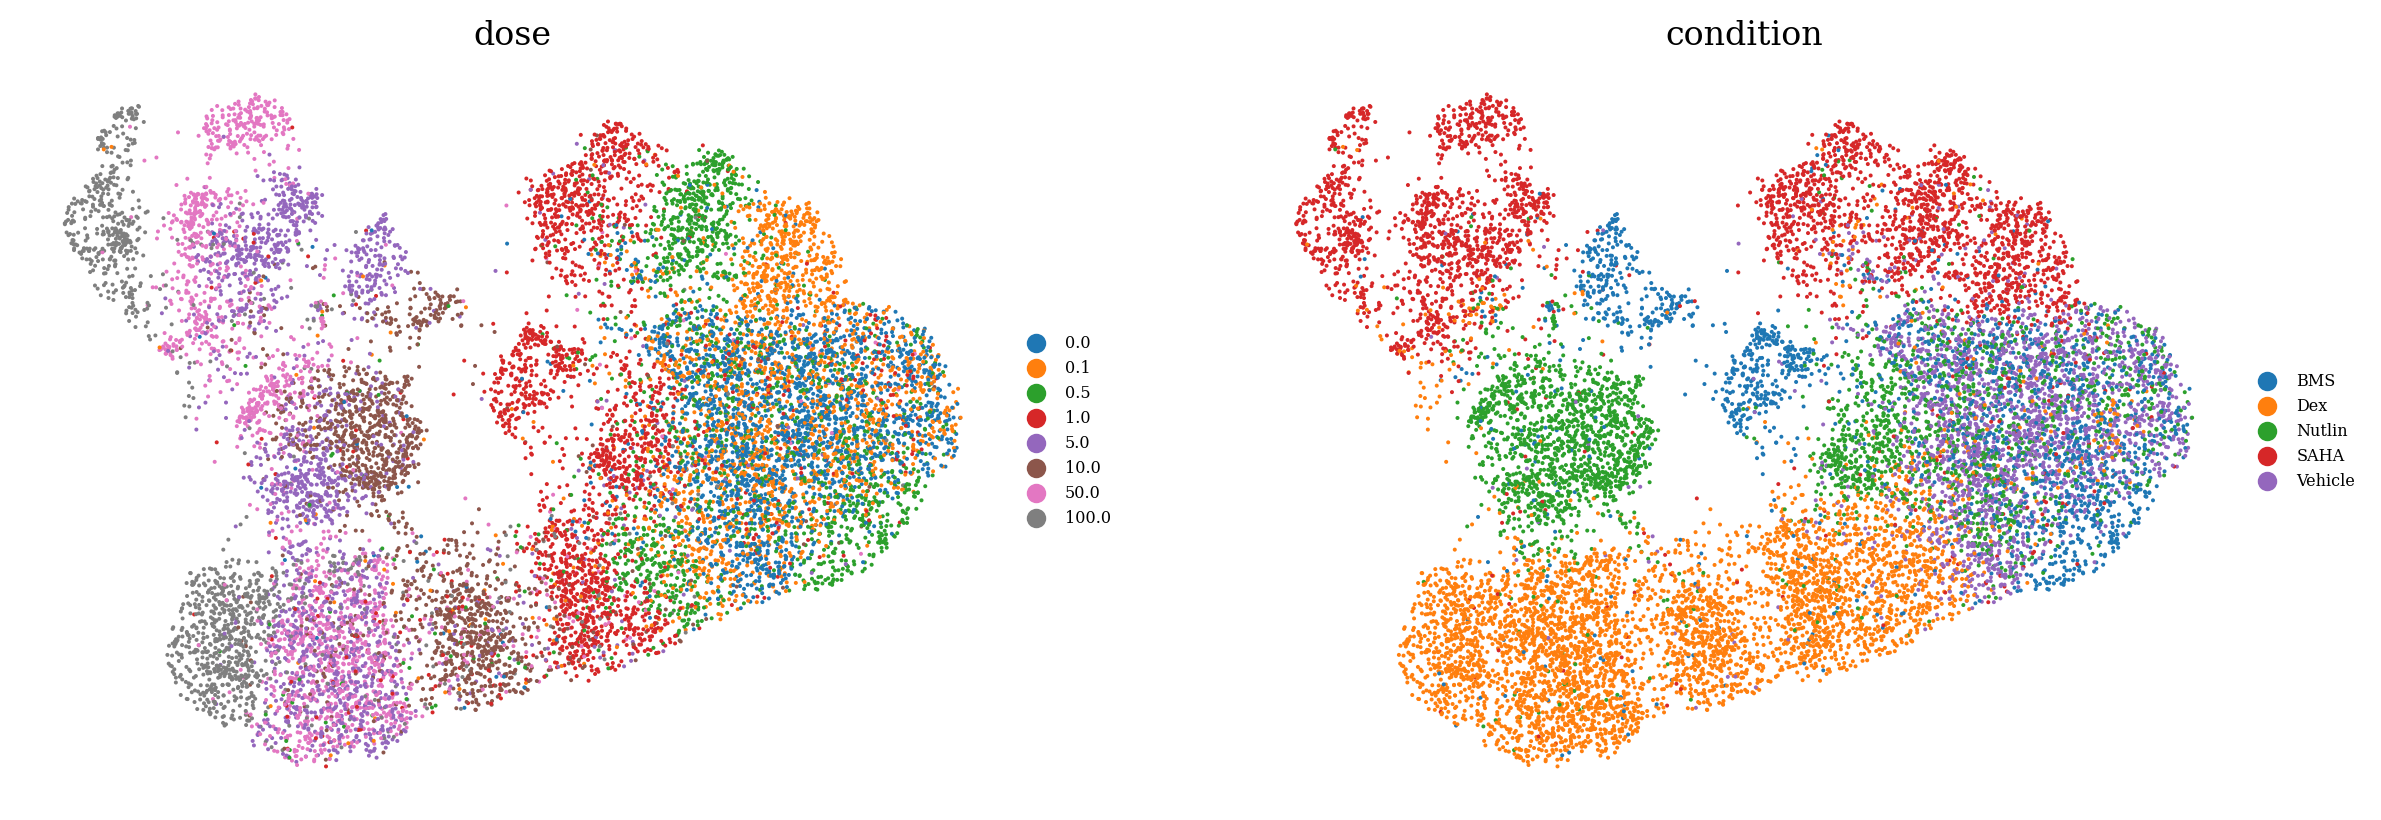

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

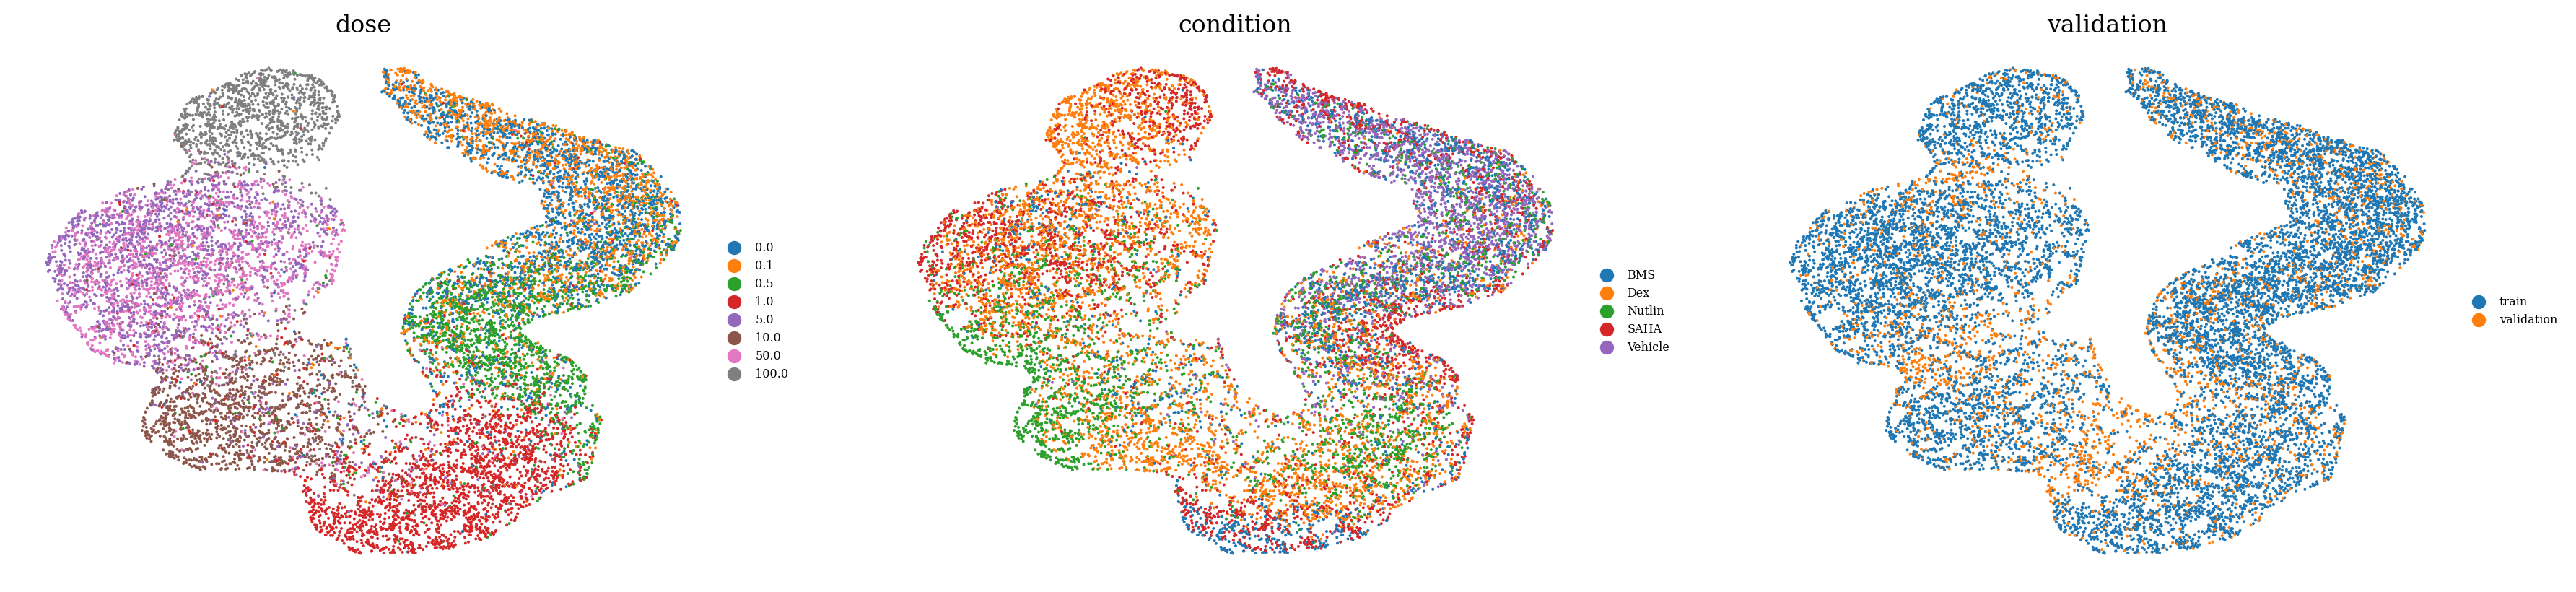

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [27]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


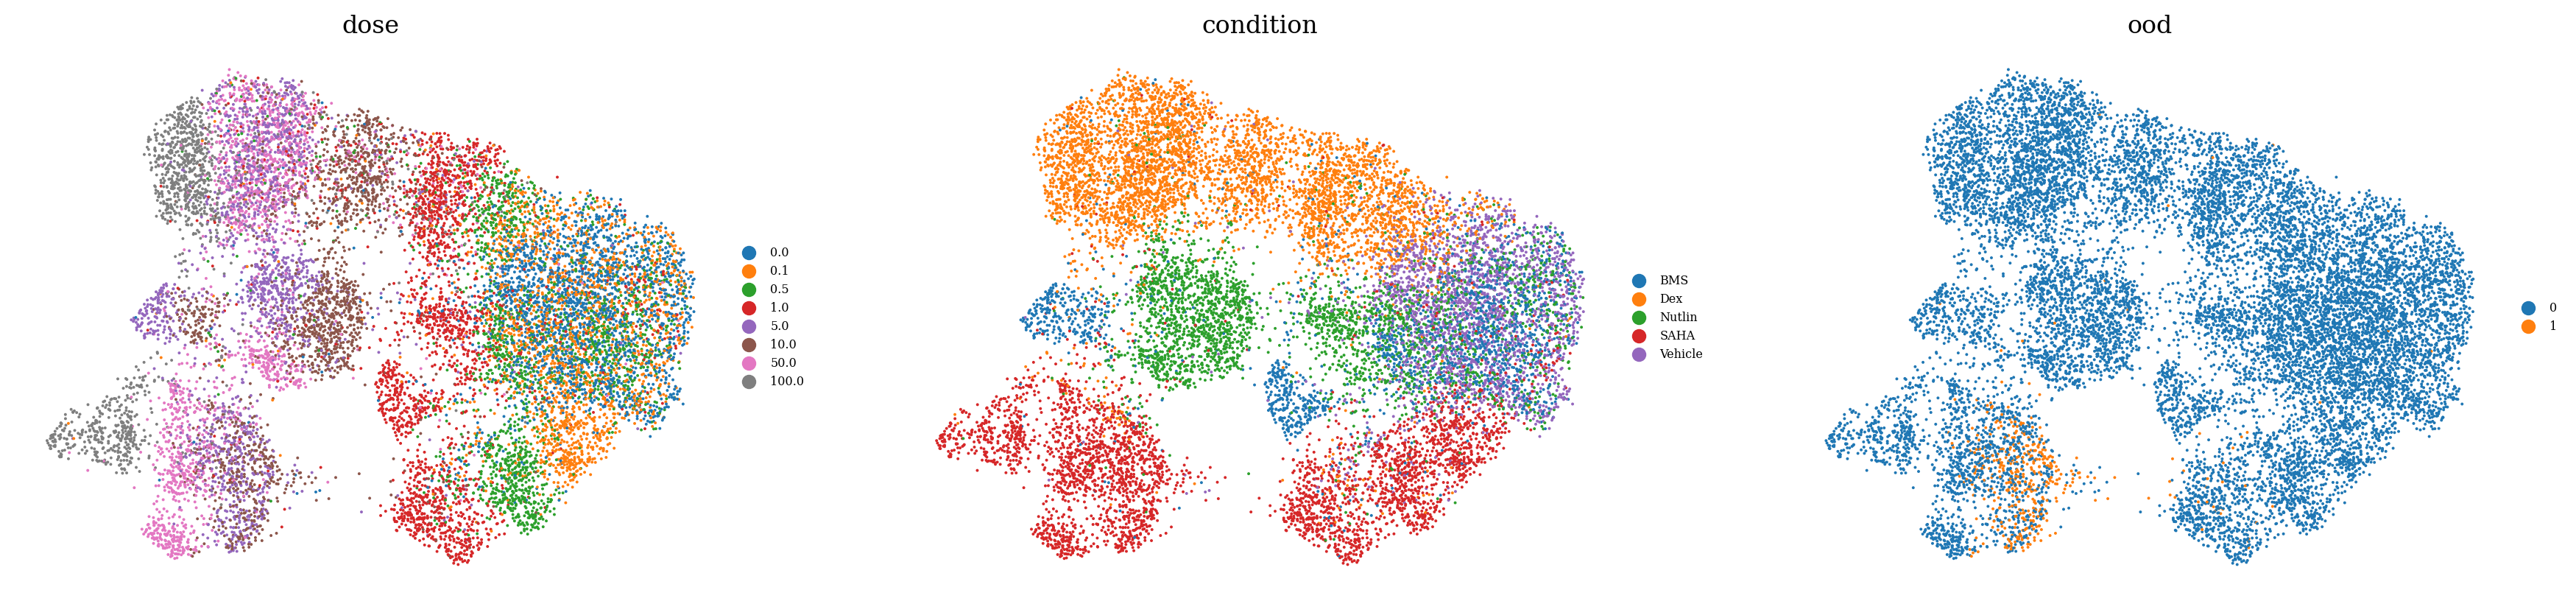

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [29]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


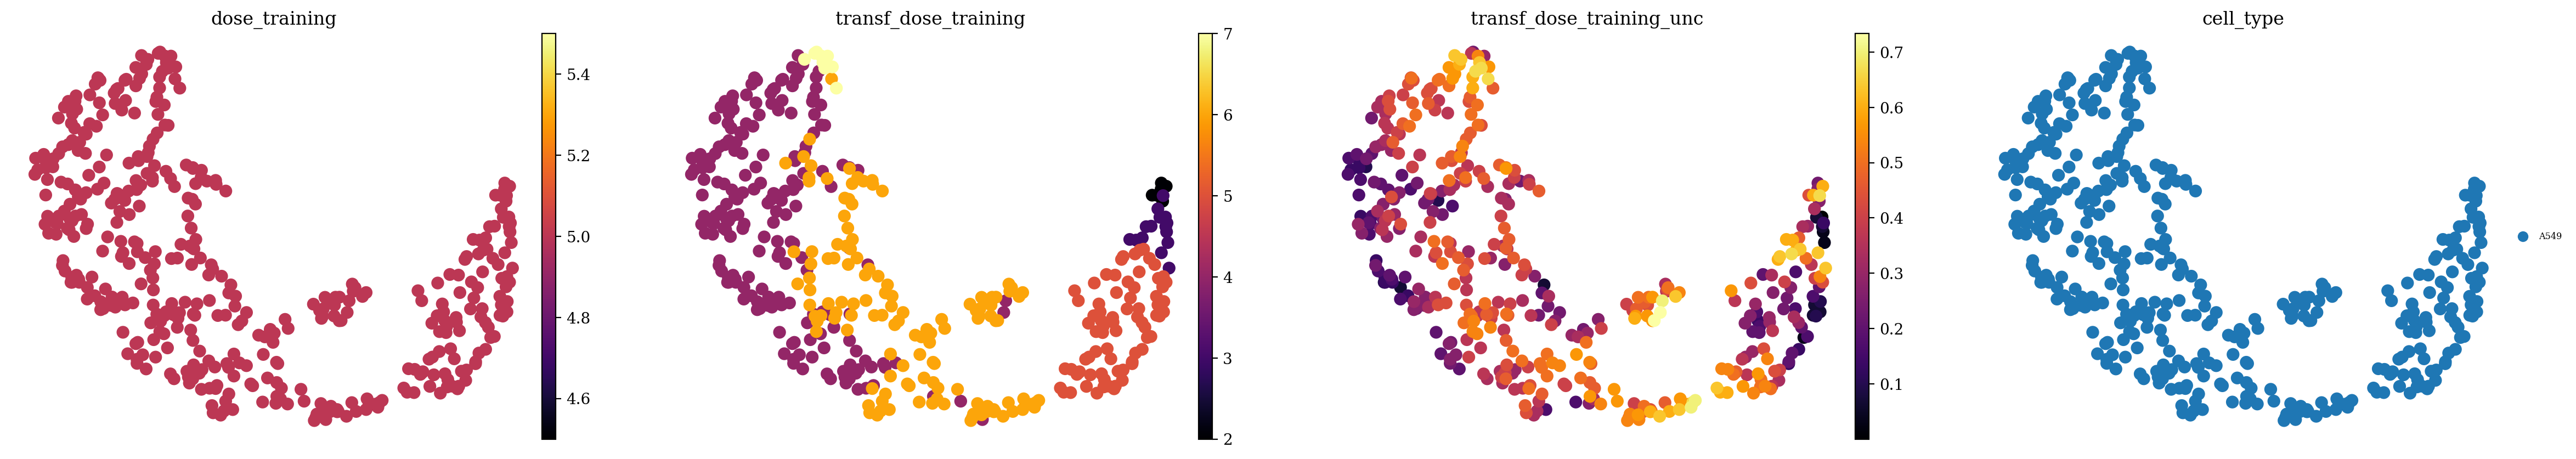

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.17370892018779344,
 'precision_macro': 0.16666666666666666,
 'recall_macro': 0.028951486697965573,
 'f1_score_macro': 0.04933333333333333,
 'precision_micro': 0.17370892018779344,
 'recall_micro': 0.17370892018779344,
 'f1_score_micro': 0.17370892018779344,
 'precision_weighted': 1.0,
 'recall_weighted': 0.17370892018779344,
 'f1_score_weighted': 0.296,
 'confusion_matrix': array([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0],
        [  6,  15, 193,  74, 129,   9],
        [  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0]])}

In [32]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.14658024441293632


In [33]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.13071365876713253
